<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ridge_regression
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np
import copy

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (d, d) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (d * n, d)
        n, d = X.shape
        q = compute_q(p)

        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(d)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", n," ", d)
        print("y shape", y.shape)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", d*n)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        #if np.sum(S_mis * S_mis) == 0:
        if np.all(S_dict['S_mis'] == 0):
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        else:  # S_mis.shape == (n, d, d):
          S_dts_tiled = np.concatenate([S_dts] * n)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (d, d):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (d * n, d):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (n, d), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / n * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []

# dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}
def get_path(X, y, estimator, S_dict): #eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape

    if S_dict['algo_superv_learn'] == 'adv':
      #n_a_dts = S_dict['n_a_dts']
      #a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
      #a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']

      if np.all(S_dict['S_dts'] == 0):
        n_a_dts, a_d_dts_max, a_d_dts_min = 1, 0, 0
      else:
        n_a_dts = S_dict['n_a_dts']
        a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
        a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']

      if np.all(S_dict['S_mis'] == 0):
        n_a_mis, a_d_mis_max, a_d_mis_min = 1, 0, 0
      else:
        n_a_mis = S_dict['n_a_mis']
        a_d_mis_max = S_dict['adv_rad_times_delta_mis_max']
        a_d_mis_min = a_d_mis_max * S_dict['eps_adv_rad_times_delta_mis']


      if a_d_dts_max < 0 or a_d_mis_max < 0 or n_a_dts < 1 or n_a_mis <1:
        print("WARNING: some bad values for the grid of cross validation, the number of grid point should be strictly potive, the radius strictly positive")
      alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts) if a_d_dts_max > 0 else np.zeros(1)
      alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis) if a_d_mis_max > 0 else np.zeros(1)
      #alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts)
      #alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis)
      print("dts deltas ", alphas_dts)
      print("mis deltas ", alphas_mis)
      #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
      hyper_p_ret_ = []
      coefs_ = []
      for a_mis_value in tqdm.tqdm(alphas_mis):
        for a_dts_value in tqdm.tqdm(alphas_dts):
            #tuple_key = (scale_dts_value, scale_mis_value)
            #coefs_ = []
            #for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
              #print("dict hyper in get path ", dict_hyper_p_values)
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a_dts_value, a_mis_value])
            #res[tuple_key] = np.stack((coefs_)).T
    elif S_dict['algo_superv_learn'] == 'ridge':
      n_a_rid = S_dict['n_a_rid']
      a_rid_max = S_dict['alpha_ridge_reg_max']
      a_rid_min = a_rid_max * S_dict['eps_alpha_ridge_reg']
      alphas_rid = np.logspace(np.log10(a_rid_min), np.log10(a_rid_max), n_a_rid) if a_rid_max > 0 else np.zeros(1)
      print("rid alphas ", alphas_rid)
      hyper_p_ret_ = []
      coefs_ = []
      print("S_dts_inv in get path, ridge regression \n", S_dict['S_dts'])
      S_dts_inv = np.linalg.inv(S_dict['S_dts'])  # (d, d)
      print("S_dts_inv in get path, ridge regression \n", S_dts_inv)
      for a_rid in tqdm.tqdm(alphas_rid):
            #dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
            #print("dict hyper in get path ", dict_hyper_p_values)
            coefs = estimator(X @ S_dts_inv, y, a_rid)
            coefs = S_dts_inv @ coefs
            print("alpha  ", a_rid, "coef_ridge: ", coefs)
            coefs_.append(coefs if coefs is not None else np.zeros(m))
            hyper_p_ret_.append([a_rid, 0])  #([a_dts_value, a_mis_value])


    '''
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

#dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg': 1,
#                             'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'eps_alpha_ridge_reg': 1e-4,
#                             'n_a_dts': 25, 'n_a_mis':4, 'n_a_rid': 25}}





'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):

    if S_dict['algo_superv_learn'] == 'adv':
      linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
      estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
    elif S_dict['algo_superv_learn'] == 'ridge':
      estimator = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False)#, random_state=0)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
      #estimator = lambda X, y, a: linear_model.Ridge(alpha=a).fit(X, y).coef_
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf


X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)

alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=True, random_state=0)
for a in alphas:
  coef, intercept = estim(X, y, a)
  print("coef : ", coef)
  print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  print("coef : ", coef)
  print("intercpt ", intercept)


'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
coef :  [ 1.98514397 -1.00500106  0.00379175  0.00750503]
intercpt  -0.005116931375030355
coef :  [ 1.98514397 -1.00500106  0.00379175  0.00750503]
intercpt  -0.005116931375030355
coef :  [ 1.9851211  -1.0049879   0.00379016  0.00751155]
intercpt  -0.005115352570976787
coef :  [ 1.9851211  -1.0049879   0.00379016  0.00751155]
intercpt  -0.005115352570976787
coef :  [ 1.98239903 -1.00366838  0.00333485  0.00823663]
intercpt  -0.004923599744247874
coef :  [ 1.98239903 -1.00366838  0.00333485  0.00823663]
intercpt  -0.004923599744247874
coef :  [ 1.9620289  -0.99190809  0.00215719  0.01386457]
intercpt  -0.003602846450858347
coef :  [ 1.9620289  -0.99190809  0.00215719  0.01386457]
intercpt  -0.003602846450858347
end block


In [2]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  print("X shape in clear data ", X.shape)
  print("y shape in clear data ", y.shape)
  print("M shape in clear data ", M.shape)
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [3]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
'''
def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks
'''

def generate_masks(dictio_data):#nbr_of_sample, dim, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    dim = len(dictio_data['beta_gt'][0])
    nbr_of_sample = dictio_data['n_train'][-1]  # last one should be the biggest one
    p_missing = dictio_data['p_miss'][0]
    print("p_missing in generate mask ", p_missing)
    if dim == 2:
      if len(p_missing) < 3:
        print("WARNING: p_missing should be a list with a length of 3 if the dimension is 2")
      masks = np.zeros((nbr_of_sample, 2))
      v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
      masks[v == 0, :] = np.array([0, 0])  # both seen
      masks[v == 1, :] = np.array([0, 1])  # left seen
      masks[v == 2, :] = np.array([1, 0])  # right seen
    else:
      # in this branch, p_missing = [p1,.., pl],
      masks = np.array([np.random.binomial(1, 1-pr, (nbr_of_sample, dim)) for pr in p_missing])
      masks = np.cumsum(masks, axis=0)  # each round
      masks[masks>1] = 1
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [4]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)  # size (info['mi_nbr], n, d)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        #s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = std_vectors[:, None, :] * np.eye(std_vectors.shape[-1])  # should be (m, d, d), with each diagonal the diagonals of std_vectors
        #S = s_within
        #S = np.diag(s_within)
        print("final S.shape in cov strategy std_mi ", S.shape)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure'] and 'cov_strategy_between' in info.keys():
      m, n, d = X_imputed.shape
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
        if info['post_imp'] == 'conc':
          S_mis = np.tile(S_mis, (m, 1, 1))
      elif info['cov_strategy_between'] == 'zero':
        d = dict_observations['X_test'].shape[-1]
        S_mis = np.zeros((d, d))
    else:  # not using a mi method, so uncertainty on missing part should be zero
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      print("shape X_imputed ", X_imputed.shape)
      X_train = np.concatenate(X_imputed)
      y_train = np.tile(y_train, X_imputed.shape[0])
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'LogNormal':
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.lognormal(mean=data['mean'], sigma=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim) -0.5
    elif data['data'] == 'Logistic':
      X_complete = np.random.logistic(loc=0.0, scale=1.0, size=(n_tot, dim))
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    elif err['type'] == 'Uniform_on_X':
      error = ((np.random.rand(n_tot, dim)-0.5) @ beta_gt) * err['scaling']
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    # masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    # masks_train = generate_masks_binomial(n_train, p_miss)  # 1 missing, 0 observed
    #X_train, y_train, masks_train = clear_dataset(X_train, y_train, masks_train)
    # M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    # dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, []), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      print("NO PREVIOUS IMPUTATION HAS BEEN DONE")
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      print("A PREVIOUS IMPUTATION HAS BEEN DONE")
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) #* dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  #* dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    if 'post_imp' in dict_obs.keys():
      if dict_obs['post_imp'] == 'conc':
        print(S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing} | dict_obs['info_algo'] | {'algo_superv_learn': dict_imp['algo_superv_learn']}  # , 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    # dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}

    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_full_seen (train): ", np.sum(M == 0), " nbr_at_least_one_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi' and dict_imp['cov_strategy'] == 'std_mi':  # run a standard multiple imputation procedure
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      min_score = 0
      temporary_dictionary = copy.deepcopy(S_dict)
      for i in range(dict_imp['mi_nbr']):
        print("i  mi .-------------> ", i)
        #dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        #dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        #S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        #S = S_within[None, :, :] + S_between
        #S = np.concatenate(S, axis=0)
        #print(S)
        #alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        temporary_dictionary['S_dts'] = S_dict['S_dts'][i, :, :]
        print("temporary dict ", temporary_dictionary)
        hyper_p_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, temporary_dictionary, [])
        idx_best, min_score_partial = best_idx_predictor(X_test, coeff_results, y_test)
        print("weee ", idx_best)
        print(coeff_results.shape)
        print(hyper_p_used.shape)
        best_coeff_partial, _ = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        min_score += min_score_partial
        #best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
      best_coeff /= dict_imp['mi_nbr']
      min_score /=  dict_imp['mi_nbr']
      best_hyper_p = 0  # not important right now
      best_alpha_delta_dts = 1  # not important right now
      #best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha_delta_dts, best_alpha_delta_mis = best_hyper_p[0], best_hyper_p[1]
#     print("best alpha ----> ", best_alpha_dts)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = S_dict['S_dts'] * best_alpha_delta_dts + S_dict['S_mis'] * best_alpha_delta_mis
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
    #print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])


    # obsere that one day you shoul add the return of alpha_delta_mis also
    return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)



In [5]:
def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])  # how many trials shall we do
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_hyper_p':[], 'best_alpha_dts':[], 'best_alpha_mis':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed  = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][-1],  # last one should be the biggest
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][-1],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0]
                                             )  # return {'X_train_masked':(X_train, mask_train) , 'X_test':.., 'y_train':, 'y_test'}
      #mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen
      full_masks = generate_masks(dictio)
    dictio_obser_fixed_copy = copy.deepcopy(dictio_obser_fixed)

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        if len(dictio['beta_gt'][0]) == 2:
          #mask_partial = dict_obser_partial['X_train_masked'][1]
          p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
          n_train = full_masks.shape[0]
          mask_partial = full_masks.copy()
          mask_partial[0:int(n_train * p_i), :] = 0
          tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
          dict_obser['X_train_masked'] = tuple_partial
        else:
          #print("size in run experiment", dictio_obser_fixed_copy['X_train_masked'][0].shape, "wee ", dictio_obser_fixed['y_train'].shape)
          ## we use the next line of code with dictio_obser_fixed_copy because we need to test the mask with the original dataset, otherwise we get size error (the dataset change if an observation get fully hidden)
          n_train = dictio['n_train']
          print("n_tot_fll ", n_train, ",  ", n_train[i])
          #print(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :].shape)
          #print(dictio_obser_fixed_copy['X_train_masked'][0].shape)
          X_train_cleaned, y_train_cleaned, masks_train_cleaned = clear_dataset(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :], dictio_obser_fixed_copy['y_train'][0:n_train[i]], full_masks[i][0:n_train[i], :])
          print("shapes X_train cleaned, mask train cleaned, y train cleaned")
          print(X_train_cleaned.shape)
          print(masks_train_cleaned.shape)
          print(y_train_cleaned.shape)
          #tuple_partial = (dictio_obser_fixed['X_train_masked'][0], full_masks[i])
          print("full masks in run experiment ", full_masks[i])
          dict_obser['X_train_masked'] = (X_train_cleaned, masks_train_cleaned)
          dict_obser['y_train'] = y_train_cleaned
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      print("info algo in run experiments ", dictio['info_algo'])
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}} | {'info_algo': dictio['info_algo']}  # add an entry for imputed dataset, and info for algorithm
      print("ciaoooooo dict obser in run experiments \n ", dict_obser)
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, hyper_p_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, hyper_p_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_hyper_p'].append(hyper_p_round)  # both hyperparameters
        res[key_tuple]['best_alpha_dts'].append(hyper_p_round[0])  # one of the hyperparameter
        res[key_tuple]['best_alpha_mis'].append(hyper_p_round[1])  # the other hyperparameter

        #res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  lb = extra_info['what_to_plot']
  nbr_plot = len(lb)
  fig_res, ax_res = plt.subplots(1, nbr_plot,
                                 figsize=(45 * (nbr_plot / 3 ), 7.5))  # , num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key in plot_res", key, ": values\n", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  # lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(nbr_plot):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      print("lb[i] in plot_res ", lb[i], "  ", dictio[lb[i]])
      print("key: ", key)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key), color=key[-1])  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=20,)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2", fontweight='bold', fontsize=16)
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test", fontweight='bold', fontsize=16)
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'], fontweight='bold', fontsize = 24)
  ax_res[1].set_title(extra_info['title_test_error'], fontweight='bold', fontsize = 24)
  ax_res[2].set_title(extra_info['title_dts_radius'], fontweight='bold', fontsize = 24)
  ax_res[3].set_title(extra_info['title_mis_radius'], fontweight='bold', fontsize = 24)
  ax_res[2].set_ylabel("-log10(alpha)", fontsize=16, fontweight='bold')
  ax_res[3].set_ylabel("-log10(alpha)", fontsize=16, fontweight='bold')
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  #rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  '''
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])
  '''
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      print("res partial \n")
      for k, value in res_partial.items():
        print("key: ", k, " value: ", value)
      plot_res(info_x_axis, res_partial, dictio)
      print("res in run multipl experiments\n")
#      for k, value in res.items():
#        print("key: ", k, " value: ", value)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_hyper_p'].append(res_partial[k]['best_hyper_p'])
        res[k]['best_alpha_dts'].append(res_partial[k]['best_alpha_dts'])
        res[k]['best_alpha_mis'].append(res_partial[k]['best_alpha_mis'])

        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




[ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
change nbr_experiments to match the size of n_train
data :  [{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.03998415,  2.38833027, -0.86246421,  3.28768588,  0.69845347,
        -0.90035313],
       [ 2.38833027,  4.50994003, -1.8320033 ,  0.86589567,  2.20052825,
         0.56404508],
       [-0.86246421, -1.8320033 ,  6.92125709,  1.30980468, -0.43000617,
        -1.59493872],
       [ 3.28768588,  0.86589567,  1.30980468,  6.00140979,  1.06705937,
        -1.98890434],
       [ 0.69845347,  2.20052825, -0.43000617,  1.06705937, 11.39466092,
         1.5504456 ],
       [-0.90035313,  0.56404508, -1.59493872, -1.98890434,  1.5504456 ,
         2.54748646]])}, {'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0]), 'cov': array([[ 4.03998415,  2.38833027, -0.86246421,  3.28768588,  0.69845347,
        -0.90035313],
       [ 2.38833027,  4.50994003, -1.8320033 ,  0.86589567,  2.20052825,


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02682696 0.        ] , min score  0.001904021153944618
---------------------------------> best coeff  [ 1.0520635  -0.94153405 -0.34258536 -0.78470396 -0.33032288  0.57555785]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27114457 0.31074478 0.28214629 0.30467968 0.28388717 0.30358351]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -20.993306662562567
[3 2 1 0 3 1 1 1 3 2 2 2 1 0 3 2 2 1 1 0 3 1 1 2 1 1 2 2 1 2 1 1 1 1 2 2 2
 1 2 1 0 2 1 2 1 3 2 0 2 1 1 1 1 1 0 2 3 0 2 2 3 0 0 2 1 0 1 3 2 2 0 1 3 2
 2 3 2 1 1 2 0 2 1 1 1 0 2 1 0 2 1 1 0 0 0 1 1 2 2]
S dataset 
 [[0.2710149

100%|██████████| 50/50 [00:00<00:00, 425.65it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.06622355 -0.95684152 -0.36233189 -0.82614207 -0.38058667  0.60595769]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.0662235  -0.95684147 -0.36233189 -0.82614199 -0.38058661  0.60595766]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.06622342 -0.95684141 -0.36233188 -0.82614188 -0.38058651  0.60595762]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.06622332 -0.95684132 -0.36233186 -0.82614174 -0.38058637  0.60595756]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.06622317 -0.95684121 -0.36233185 -0.82614153 -0.38058619  0.60595748]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.06622297 -0.95684104 -0.36233182 -0.82614125 -0.38058593  0.60595737]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.06622269 -0.95684081 -0.36233178 -0.82614085 -0.38058557  0.60595721]
alpha   0.0001 coef_ridge:  [ 1.0662223  -0.95684049 -0.36233173 -0.8261403  -0.38058507  0.60595699]
alpha   0.00013894954943731373 coef_ridge:  [ 1.06622176 -0.95684005 -0.36233167 -0.8261395

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.07196857 0.        ] , min score  1.2527993023410034e-20
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27114457 0.31074478 0.28214629 0.30467968 0.28388717 0.30358351]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -13.343116000915463
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0

100%|██████████| 50/50 [00:00<00:00, 504.42it/s]


alpha   1e-05 coef_ridge:  [ 1.03195047 -1.04765099 -0.28116542 -0.70636865 -0.36084366  0.59262352]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195044 -1.04765094 -0.28116541 -0.70636862 -0.36084364  0.5926235 ]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195038 -1.04765088 -0.28116541 -0.70636857 -0.36084361  0.59262346]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195031 -1.0476508  -0.2811654  -0.70636851 -0.36084357  0.59262342]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195021 -1.04765069 -0.28116539 -0.70636842 -0.36084351  0.59262335]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195006 -1.04765053 -0.28116538 -0.7063683  -0.36084342  0.59262327]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03194987 -1.04765031 -0.28116537 -0.70636814 -0.36084331  0.59262314]
alpha   0.0001 coef_ridge:  [ 1.03194959 -1.04765    -0.28116534 -0.7063679  -0.36084315  0.59262297]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03194921 -1.04764957 -0.28116531 -0.7063675

/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


crush test------------------------------------------------->  -24.096707057365613
[3 2 1 0 3 1 1 1 3 2 2 2 1 0 3 2 2 1 1 0 3 1 1 2 1 1 2 2 1 2 1 1 1 1 2 2 2
 1 2 1 0 2 1 2 1 3 2 0 2 1 1 1 1 1 0 2 3 0 2 2 3 0 0 2 1 0 1 3 2 2 0 1 3 2
 2 3 2 1 1 2 0 2 1 1 1 0 2 1 0 2 1 1 0 0 0 1 1 2 2 3 2 1 1 1 1 1 0 1 3 3 2
 1 1 1 2 2 1 3 2 1 2 2 0 1 1 1 0 0 1 1 2 4 1 2 3 1 0 2 1 0 0 1 1 1 0 0 1 1
 4 2 0 0 1 1 0 4 3 1 0 2 2 1 0 1 4 2 3 0 2 1 1 1 1 3 1 1 2 1 1 3 1 2 0 2 2
 1 2 3 2 1 1 2 2 1 3 3 1 1 0]
S dataset 
 [[0.27157913 0.         0.         0.         0.         0.        ]
 [0.         0.29665936 0.         0.         0.         0.        ]
 [0.         0.         0.27740654 0.         0.         0.        ]
 [0.         0.         0.         0.30281687 0.         0.        ]
 [0.         0.         0.         0.         0.29177466 0.        ]
 [0.         0.         0.         0.         0.         0.28846359]]
shape oject in cov strategy missing  6
shape oject in cov strategy missing  (20000, 6)

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.0011241386474457728
---------------------------------> best coeff  [ 1.01751177 -0.99259961 -0.32751777 -0.66503816 -0.3210356   0.52393943]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27838075 0.30141581 0.27577455 0.29606532 0.2902356  0.29781222]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.096707057365613
[3 2 1 0 3 1 1 1 3 2 2 2 1 0 3 2 2 1 1 0 3 1 1 2 1 1 2 2 1 2 1 1 1 1 2 2 2
 1 2 1 0 2 1 2 1 3 2 0 2 1 1 1 1 1 0 2 3 0 2 2 3 0 0 2 1 0 1 3 2 2 0 1 3 2
 2 3 2 1 1 2 0 2 1 1 1 0 2 1 0 2 1 1 0 0 0 1 1 2 2 3 2 1 1 1 1 1 0 1 3 3 2
 1 1 1 2

100%|██████████| 50/50 [00:00<00:00, 503.72it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.01752218 -0.99260459 -0.32752931 -0.66504405 -0.32104966  0.52394465]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.01752215 -0.99260456 -0.32752931 -0.66504403 -0.32104965  0.52394464]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.01752211 -0.99260453 -0.3275293  -0.665044   -0.32104963  0.52394462]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.01752206 -0.99260448 -0.32752929 -0.66504396 -0.3210496   0.52394459]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.01752199 -0.99260442 -0.32752928 -0.6650439  -0.32104956  0.52394456]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.01752189 -0.99260433 -0.32752926 -0.66504383 -0.32104951  0.52394451]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.01752175 -0.9926042  -0.32752924 -0.66504372 -0.32104943  0.52394444]
alpha   0.0001 coef_ridge:  [ 1.01752155 -0.99260403 -0.32752921 -0.66504358 -0.32104933  0.52394434]
alpha   0.00013894954943731373 coef_ridge:  [ 1.01752128 -0.99260379 -0.32752917 -0.6650433

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  9.333115558407096e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27838075 0.30141581 0.27577455 0.29606532 0.2902356  0.29781222]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -18.859748618563575
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.

100%|██████████| 50/50 [00:00<00:00, 967.66it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195051 -1.04765104 -0.28116542 -0.70636869 -0.36084369  0.59262355]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195049 -1.04765102 -0.28116542 -0.70636867 -0.36084368  0.59262353]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195046 -1.04765099 -0.28116542 -0.70636864 -0.36084367  0.59262351]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195042 -1.04765095 -0.28116541 -0.70636861 -0.36084365  0.59262349]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195036 -1.04765089 -0.28116541 -0.70636856 -0.36084362  0.59262345]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195027 -1.04765081 -0.2811654  -0.70636849 -0.36084358  0.5926234 ]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195016 -1.0476507  -0.28116539 -0.7063684  -0.36084353  0.59262333]
alpha   0.0001 coef_ridge:  [ 1.03195    -1.04765055 -0.28116537 -0.70636827 -0.36084345  0.59262323]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03194977 -1.04765034 -0.28116535 -0.7063680

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.0006245619640337611
---------------------------------> best coeff  [ 1.01850106 -1.03736528 -0.28710655 -0.64248385 -0.32875095  0.54778926]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28634311 0.29114637 0.28153225 0.3006211  0.29548804 0.29503253]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -22.129087603825003
[3 2 1 0 3 1 1 1 3 2 2 2 1 0 3 2 2 1 1 0 3 1 1 2 1 1 2 2 1 2 1 1 1 1 2 2 2
 1 2 1 0 2 1 2 1 3 2 0 2 1 1 1 1 1 0 2 3 0 2 2 3 0 0 2 1 0 1 3 2 2 0 1 3 2
 2 3 2 1 1 2 0 2 1 1 1 0 2 1 0 2 1 1 0 0 0 1 1 2 2 3 2 1 1 1 1 1 0 1 3 3 2
 1 1 1 2

100%|██████████| 50/50 [00:00<00:00, 852.19it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.0185098  -1.03737263 -0.2871111  -0.64248707 -0.32875927  0.54779461]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.01850978 -1.03737262 -0.2871111  -0.64248706 -0.32875926  0.5477946 ]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.01850976 -1.03737259 -0.2871111  -0.64248704 -0.32875925  0.54779459]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.01850973 -1.03737256 -0.2871111  -0.64248702 -0.32875923  0.54779457]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.01850968 -1.03737251 -0.28711109 -0.64248698 -0.32875921  0.54779455]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.01850962 -1.03737245 -0.28711108 -0.64248693 -0.32875917  0.54779451]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.01850954 -1.03737236 -0.28711108 -0.64248687 -0.32875913  0.54779447]
alpha   0.0001 coef_ridge:  [ 1.01850942 -1.03737224 -0.28711106 -0.64248678 -0.32875906  0.5477944 ]
alpha   0.00013894954943731373 coef_ridge:  [ 1.01850925 -1.03737208 -0.28711104 -0.6424866

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  8.134984671478236e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28634311 0.29114637 0.28153225 0.3006211  0.29548804 0.29503253]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -18.34571200409369
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 

100%|██████████| 50/50 [00:00<00:00, 934.00it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195054 -1.04765106 -0.28116542 -0.7063687  -0.3608437   0.59262356]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195052 -1.04765105 -0.28116542 -0.70636869 -0.3608437   0.59262355]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.0319505  -1.04765103 -0.28116542 -0.70636868 -0.36084369  0.59262354]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195048 -1.047651   -0.28116542 -0.70636866 -0.36084368  0.59262352]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195044 -1.04765096 -0.28116541 -0.70636863 -0.36084366  0.5926235 ]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195039 -1.04765091 -0.28116541 -0.70636858 -0.36084364  0.59262347]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195031 -1.04765084 -0.2811654  -0.70636852 -0.36084361  0.59262342]
alpha   0.0001 coef_ridge:  [ 1.03195021 -1.04765074 -0.2811654  -0.70636844 -0.36084356  0.59262336]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03195007 -1.0476506  -0.28116538 -0.7063683

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.0015117424518151332
---------------------------------> best coeff  [ 1.03323356 -1.05769159 -0.2990804  -0.59043461 -0.29606076  0.58316837]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28520559 0.29231838 0.28396464 0.29428393 0.29244011 0.29229428]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.075408130838312
[3 2 1 0 3 1 1 1 3 2 2 2 1 0 3 2 2 1 1 0 3 1 1 2 1 1 2 2 1 2 1 1 1 1 2 2 2
 1 2 1 0 2 1 2 1 3 2 0 2 1 1 1 1 1 0 2 3 0 2 2 3 0 0 2 1 0 1 3 2 2 0 1 3 2
 2 3 2 1 1 2 0 2 1 1 1 0 2 1 0 2 1 1 0 0 0 1 1 2 2 3 2 1 1 1 1 1 0 1 3 3 2
 1 1 1 2

100%|██████████| 50/50 [00:00<00:00, 881.23it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03324065 -1.05770084 -0.29908468 -0.59043937 -0.29606982  0.58317697]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03324063 -1.05770082 -0.29908468 -0.59043936 -0.29606982  0.58317696]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03324062 -1.05770081 -0.29908468 -0.59043935 -0.29606981  0.58317695]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03324059 -1.05770078 -0.29908467 -0.59043933 -0.2960698   0.58317694]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03324056 -1.05770075 -0.29908467 -0.59043931 -0.29606978  0.58317692]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03324051 -1.0577007  -0.29908466 -0.59043927 -0.29606976  0.58317689]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03324045 -1.05770063 -0.29908465 -0.59043923 -0.29606974  0.58317686]
alpha   0.0001 coef_ridge:  [ 1.03324036 -1.05770054 -0.29908464 -0.59043917 -0.2960697   0.58317681]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03324023 -1.05770041 -0.29908462 -0.5904390

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  9.025271588894943e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28520559 0.29231838 0.28396464 0.29428393 0.29244011 0.29229428]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -22.49804306449232
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 

100%|██████████| 50/50 [00:00<00:00, 856.24it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195055 -1.04765107 -0.28116542 -0.70636871 -0.36084371  0.59262357]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195054 -1.04765106 -0.28116542 -0.7063687  -0.3608437   0.59262356]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195052 -1.04765105 -0.28116542 -0.70636869 -0.3608437   0.59262355]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.0319505  -1.04765103 -0.28116542 -0.70636867 -0.36084369  0.59262354]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195048 -1.047651   -0.28116541 -0.70636865 -0.36084367  0.59262353]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195044 -1.04765096 -0.28116541 -0.70636862 -0.36084366  0.5926235 ]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195038 -1.04765091 -0.2811654  -0.70636857 -0.36084363  0.59262348]
alpha   0.0001 coef_ridge:  [ 1.03195031 -1.04765084 -0.28116539 -0.70636851 -0.3608436   0.59262343]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03195021 -1.04765074 -0.28116538 -0.7063684

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.0006220715297526107
---------------------------------> best coeff  [ 1.0184379  -1.0650493  -0.25072828 -0.6515254  -0.30619672  0.6007112 ]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28712544 0.29285824 0.28365277 0.29353827 0.29280805 0.29399193]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -29.21644965544472
[3 2 1 0 3 1 1 1 3 2 2 2 1 0 3 2 2 1 1 0 3 1 1 2 1 1 2 2 1 2 1 1 1 1 2 2 2
 1 2 1 0 2 1 2 1 3 2 0 2 1 1 1 1 1 0 2 3 0 2 2 3 0 0 2 1 0 1 3 2 2 0 1 3 2
 2 3 2 1 1 2 0 2 1 1 1 0 2 1 0 2 1 1 0 0 0 1 1 2 2 3 2 1 1 1 1 1 0 1 3 3 2
 1 1 1 2 

100%|██████████| 50/50 [00:00<00:00, 979.32it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.01844406 -1.06506055 -0.25073361 -0.65153195 -0.30620272  0.60071965]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.01844405 -1.06506053 -0.25073361 -0.65153195 -0.30620271  0.60071964]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.01844403 -1.06506052 -0.25073361 -0.65153193 -0.30620271  0.60071964]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.01844401 -1.0650605  -0.25073361 -0.65153192 -0.3062027   0.60071963]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.01844399 -1.06506047 -0.2507336  -0.6515319  -0.30620269  0.60071961]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.01844395 -1.06506043 -0.2507336  -0.65153187 -0.30620267  0.60071959]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.0184439  -1.06506037 -0.25073359 -0.65153183 -0.30620264  0.60071957]
alpha   0.0001 coef_ridge:  [ 1.01844383 -1.06506029 -0.25073358 -0.65153177 -0.30620261  0.60071953]
alpha   0.00013894954943731373 coef_ridge:  [ 1.01844373 -1.06506018 -0.25073356 -0.6515316

100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  8.675550546572858e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28712544 0.29285824 0.28365277 0.29353827 0.29280805 0.29399193]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -27.132730295916936
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.

100%|██████████| 50/50 [00:00<00:00, 837.47it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195055 -1.04765107 -0.28116542 -0.70636872 -0.36084371  0.59262357]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195054 -1.04765107 -0.28116542 -0.70636871 -0.36084371  0.59262357]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195053 -1.04765105 -0.28116542 -0.7063687  -0.3608437   0.59262356]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195052 -1.04765104 -0.28116542 -0.70636869 -0.36084369  0.59262355]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.0319505  -1.04765102 -0.28116541 -0.70636867 -0.36084368  0.59262354]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195047 -1.04765099 -0.28116541 -0.70636865 -0.36084367  0.59262352]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195042 -1.04765094 -0.2811654  -0.70636861 -0.36084365  0.5926235 ]
alpha   0.0001 coef_ridge:  [ 1.03195037 -1.04765088 -0.28116539 -0.70636856 -0.36084363  0.59262347]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03195029 -1.0476508  -0.28116537 -0.7063685

100%|██████████| 1/1 [00:00<00:00,  2.57it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05179475 0.        ] , min score  0.0023175320427393548
---------------------------------> best coeff  [ 1.00454746 -0.99560222 -0.34066573 -0.60921238 -0.45981331  0.55121364]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2785979  0.29821062 0.2582622  0.29982983 0.25880163 0.30175641]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -1.1802898625574008
[1 1 1 0 1 2 1 2 2 0 1 1 0 0 1 1 1 0 2 2 0 0 2 1 2 1 0 0 2 2 2 1 1 1 2 1 0
 1 2 3 2 0 1 0 1 0 1 3 1 2 0 1 2 1 2 4 0 0 0 0 1 3 2 0 1 1 2 1 3 3 2 0 2 1
 1 1 1 1 1 0 3 3 3 0 2 0 0 0 2 2 3 1 1 2 2 1 1 1 0 0]
S dataset 
 [[0.2783

100%|██████████| 50/50 [00:00<00:00, 1034.50it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.06874047 -1.02058856 -0.41287241 -0.63509977 -0.52351877  0.58033229]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.06874041 -1.02058852 -0.41287238 -0.63509973 -0.52351874  0.58033225]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.06874034 -1.02058845 -0.41287234 -0.63509969 -0.52351869  0.58033221]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.06874024 -1.02058836 -0.41287229 -0.63509962 -0.52351862  0.58033215]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.06874009 -1.02058823 -0.41287221 -0.63509953 -0.52351853  0.58033206]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.06873989 -1.02058805 -0.41287211 -0.63509941 -0.5235184   0.58033194]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.06873962 -1.02058781 -0.41287197 -0.63509923 -0.52351823  0.58033177]
alpha   0.0001 coef_ridge:  [ 1.06873924 -1.02058747 -0.41287177 -0.63509899 -0.52351798  0.58033154]
alpha   0.00013894954943731373 coef_ridge:  [ 1.0687387  -1.02058699 -0.4128715  -0.6350986

100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02682696 0.        ] , min score  7.37311159475822e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2785979  0.29821062 0.2582622  0.29982983 0.25880163 0.30175641]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  2.7153915517221066
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0

100%|██████████| 50/50 [00:00<00:00, 771.45it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195046 -1.047651   -0.28116541 -0.70636867 -0.36084367  0.59262352]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195042 -1.04765096 -0.2811654  -0.70636864 -0.36084365  0.59262349]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195036 -1.04765091 -0.28116539 -0.7063686  -0.36084363  0.59262345]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195028 -1.04765084 -0.28116538 -0.70636855 -0.36084359  0.5926234 ]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195017 -1.04765074 -0.28116536 -0.70636848 -0.36084354  0.59262334]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195001 -1.0476506  -0.28116534 -0.70636838 -0.36084347  0.59262324]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.0319498  -1.0476504  -0.2811653  -0.70636825 -0.36084337  0.59262311]
alpha   0.0001 coef_ridge:  [ 1.03194949 -1.04765013 -0.28116525 -0.70636806 -0.36084324  0.59262292]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03194907 -1.04764976 -0.28116519 -0.7063678

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05179475 0.        ] , min score  0.0021838113756117404
---------------------------------> best coeff  [ 1.00612373 -0.99309754 -0.38327689 -0.6285683  -0.34656312  0.51598209]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28620443 0.28979294 0.27125172 0.30074797 0.2716983  0.28355399]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.534706036584383
[1 1 1 0 1 2 1 2 2 0 1 1 0 0 1 1 1 0 2 2 0 0 2 1 2 1 0 0 2 2 2 1 1 1 2 1 0
 1 2 3 2 0 1 0 1 0 1 3 1 2 0 1 2 1 2 4 0 0 0 0 1 3 2 0 1 1 2 1 3 3 2 0 2 1
 1 1 1 1 1 0 3 3 3 0 2 0 0 0 2 2 3 1 1 2 2 1 1 1 0 0 1 0 1 1 1 2 2 3 1 1 1


100%|██████████| 50/50 [00:00<00:00, 556.60it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.0509002  -1.01560713 -0.47203127 -0.66037737 -0.40233696  0.54618623]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.05090017 -1.01560711 -0.47203126 -0.66037735 -0.40233694  0.54618622]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.05090013 -1.01560707 -0.47203125 -0.66037732 -0.40233692  0.5461862 ]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.05090008 -1.01560702 -0.47203122 -0.66037729 -0.40233689  0.54618617]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.05090002 -1.01560695 -0.47203119 -0.66037724 -0.40233685  0.54618612]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.05089992 -1.01560685 -0.47203115 -0.66037717 -0.4023368   0.54618606]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.05089979 -1.01560671 -0.47203109 -0.66037708 -0.40233672  0.54618598]
alpha   0.0001 coef_ridge:  [ 1.0508996  -1.01560652 -0.47203101 -0.66037695 -0.40233661  0.54618587]
alpha   0.00013894954943731373 coef_ridge:  [ 1.05089935 -1.01560626 -0.4720309  -0.6603767

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  1.0365969015975569e-20
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28620443 0.28979294 0.27125172 0.30074797 0.2716983  0.28355399]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.6700647851769261
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

100%|██████████| 50/50 [00:00<00:00, 404.26it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195052 -1.04765104 -0.28116542 -0.7063687  -0.36084369  0.59262355]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.0319505  -1.04765102 -0.28116542 -0.70636868 -0.36084368  0.59262353]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195047 -1.047651   -0.28116542 -0.70636867 -0.36084366  0.59262351]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195042 -1.04765096 -0.28116542 -0.70636864 -0.36084364  0.59262349]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195037 -1.0476509  -0.28116542 -0.7063686  -0.3608436   0.59262345]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195029 -1.04765083 -0.28116542 -0.70636855 -0.36084356  0.5926234 ]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195018 -1.04765072 -0.28116541 -0.70636848 -0.3608435   0.59262333]
alpha   0.0001 coef_ridge:  [ 1.03195002 -1.04765058 -0.28116541 -0.70636838 -0.36084341  0.59262324]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03194981 -1.04765038 -0.2811654  -0.7063682

100%|██████████| 1/1 [00:01<00:00,  1.32s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02682696 0.        ] , min score  0.0010541768231781751
---------------------------------> best coeff  [ 1.04085517 -0.98210055 -0.33698907 -0.67319573 -0.33310585  0.53571678]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28765619 0.27428052 0.27703918 0.30461    0.27383281 0.28686834]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.06408285709301076
[1 1 1 0 1 2 1 2 2 0 1 1 0 0 1 1 1 0 2 2 0 0 2 1 2 1 0 0 2 2 2 1 1 1 2 1 0
 1 2 3 2 0 1 0 1 0 1 3 1 2 0 1 2 1 2 4 0 0 0 0 1 3 2 0 1 1 2 1 3 3 2 0 2 1
 1 1 1 1 1 0 3 3 3 0 2 0 0 0 2 2 3 1 1 2 2 1 1 1 0 0 1 0 1 1 1 2 2 3 1 1 1

100%|██████████| 50/50 [00:00<00:00, 789.37it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.05846306 -0.98967041 -0.37644586 -0.68740886 -0.35381838  0.54620508]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.05846305 -0.9896704  -0.37644586 -0.68740885 -0.35381837  0.54620507]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.05846303 -0.98967038 -0.37644585 -0.68740883 -0.35381836  0.54620506]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.058463   -0.98967035 -0.37644584 -0.68740881 -0.35381835  0.54620504]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.05846295 -0.98967031 -0.37644582 -0.68740878 -0.35381833  0.54620501]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.05846289 -0.98967025 -0.3764458  -0.68740873 -0.3538183   0.54620498]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.05846281 -0.98967017 -0.37644576 -0.68740866 -0.35381826  0.54620492]
alpha   0.0001 coef_ridge:  [ 1.05846269 -0.98967007 -0.37644572 -0.68740857 -0.3538182   0.54620485]
alpha   0.00013894954943731373 coef_ridge:  [ 1.05846253 -0.98966991 -0.37644566 -0.6874084

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  1.1004266086741028e-20
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28765619 0.27428052 0.27703918 0.30461    0.27383281 0.28686834]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.184564826114925
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 

100%|██████████| 50/50 [00:00<00:00, 675.55it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195054 -1.04765106 -0.28116542 -0.70636871 -0.3608437   0.59262356]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195053 -1.04765105 -0.28116542 -0.7063687  -0.36084369  0.59262355]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195051 -1.04765103 -0.28116542 -0.70636869 -0.36084368  0.59262354]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195048 -1.04765101 -0.28116541 -0.70636867 -0.36084367  0.59262352]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195045 -1.04765098 -0.28116541 -0.70636864 -0.36084365  0.5926235 ]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.0319504  -1.04765093 -0.2811654  -0.70636861 -0.36084362  0.59262347]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195033 -1.04765087 -0.28116539 -0.70636856 -0.36084358  0.59262342]
alpha   0.0001 coef_ridge:  [ 1.03195024 -1.04765078 -0.28116538 -0.70636849 -0.36084353  0.59262336]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03195011 -1.04765065 -0.28116536 -0.7063684

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02682696 0.        ] , min score  0.0011382465804085013
---------------------------------> best coeff  [ 1.03084529 -0.98850691 -0.35648369 -0.68322286 -0.34945726  0.53111958]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28517177 0.2804289  0.27919205 0.30251564 0.27680752 0.28657998]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.667189179820225
[1 1 1 0 1 2 1 2 2 0 1 1 0 0 1 1 1 0 2 2 0 0 2 1 2 1 0 0 2 2 2 1 1 1 2 1 0
 1 2 3 2 0 1 0 1 0 1 3 1 2 0 1 2 1 2 4 0 0 0 0 1 3 2 0 1 1 2 1 3 3 2 0 2 1
 1 1 1 1 1 0 3 3 3 0 2 0 0 0 2 2 3 1 1 2 2 1 1 1 0 0 1 0 1 1 1 2 2 3 1 1 1


100%|██████████| 50/50 [00:00<00:00, 698.48it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.05013116 -1.00108932 -0.39964037 -0.70611031 -0.36738692  0.54511057]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.05013114 -1.00108931 -0.39964036 -0.7061103  -0.36738691  0.54511056]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.05013113 -1.00108929 -0.39964035 -0.70611029 -0.3673869   0.54511055]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.0501311  -1.00108927 -0.39964035 -0.70611027 -0.36738689  0.54511054]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.05013107 -1.00108924 -0.39964033 -0.70611024 -0.36738688  0.54511052]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.05013102 -1.00108919 -0.39964031 -0.7061102  -0.36738686  0.54511049]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.05013095 -1.00108913 -0.39964029 -0.70611014 -0.36738683  0.54511045]
alpha   0.0001 coef_ridge:  [ 1.05013086 -1.00108905 -0.39964025 -0.70611007 -0.36738679  0.54511039]
alpha   0.00013894954943731373 coef_ridge:  [ 1.05013074 -1.00108893 -0.3996402  -0.7061099

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  1.1104480512356441e-20
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28517177 0.2804289  0.27919205 0.30251564 0.27680752 0.28657998]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.4451687754073985
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

100%|██████████| 50/50 [00:00<00:00, 684.16it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195055 -1.04765107 -0.28116542 -0.70636871 -0.36084371  0.59262356]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195054 -1.04765106 -0.28116542 -0.70636871 -0.3608437   0.59262356]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195052 -1.04765105 -0.28116542 -0.7063687  -0.3608437   0.59262355]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195051 -1.04765103 -0.28116541 -0.70636868 -0.36084369  0.59262354]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195048 -1.04765101 -0.28116541 -0.70636866 -0.36084367  0.59262352]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195044 -1.04765097 -0.2811654  -0.70636863 -0.36084366  0.5926235 ]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195039 -1.04765092 -0.28116539 -0.70636859 -0.36084363  0.59262346]
alpha   0.0001 coef_ridge:  [ 1.03195032 -1.04765085 -0.28116538 -0.70636854 -0.3608436   0.59262342]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03195023 -1.04765076 -0.28116536 -0.7063684

100%|██████████| 1/1 [00:01<00:00,  1.34s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02682696 0.        ] , min score  0.0011041833171648973
---------------------------------> best coeff  [ 1.01061618 -1.00067535 -0.36025132 -0.65811863 -0.38505574  0.5546621 ]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28153838 0.28288322 0.28537231 0.29670018 0.27680157 0.28609638]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -2.3788742087036034
[1 1 1 0 1 2 1 2 2 0 1 1 0 0 1 1 1 0 2 2 0 0 2 1 2 1 0 0 2 2 2 1 1 1 2 1 0
 1 2 3 2 0 1 0 1 0 1 3 1 2 0 1 2 1 2 4 0 0 0 0 1 3 2 0 1 1 2 1 3 3 2 0 2 1
 1 1 1 1 1 0 3 3 3 0 2 0 0 0 2 2 3 1 1 2 2 1 1 1 0 0 1 0 1 1 1 2 2 3 1 1 1

100%|██████████| 50/50 [00:00<00:00, 615.89it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.02898737 -1.01177633 -0.3967211  -0.67801144 -0.40865886  0.57344233]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.02898736 -1.01177632 -0.39672109 -0.67801143 -0.40865886  0.57344232]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.02898735 -1.0117763  -0.39672109 -0.67801142 -0.40865885  0.57344232]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.02898733 -1.01177628 -0.39672108 -0.6780114  -0.40865884  0.5734423 ]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.02898731 -1.01177626 -0.39672107 -0.67801138 -0.40865883  0.57344229]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.02898727 -1.01177622 -0.39672105 -0.67801135 -0.40865881  0.57344226]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.02898722 -1.01177617 -0.39672103 -0.67801131 -0.40865878  0.57344223]
alpha   0.0001 coef_ridge:  [ 1.02898715 -1.0117761  -0.396721   -0.67801125 -0.40865875  0.57344218]
alpha   0.00013894954943731373 coef_ridge:  [ 1.02898705 -1.011776   -0.39672096 -0.6780111

100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  1.2387653684333738e-20
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28153838 0.28288322 0.28537231 0.29670018 0.27680157 0.28609638]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.788383324922628
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 

100%|██████████| 50/50 [00:00<00:00, 713.97it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195055 -1.04765108 -0.28116542 -0.70636872 -0.36084371  0.59262357]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195054 -1.04765107 -0.28116542 -0.70636871 -0.36084371  0.59262356]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195053 -1.04765106 -0.28116542 -0.7063687  -0.3608437   0.59262355]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195052 -1.04765104 -0.28116541 -0.70636869 -0.36084369  0.59262354]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.0319505  -1.04765102 -0.28116541 -0.70636867 -0.36084369  0.59262353]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195047 -1.04765099 -0.2811654  -0.70636865 -0.36084367  0.59262351]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195043 -1.04765096 -0.28116539 -0.70636861 -0.36084365  0.59262348]
alpha   0.0001 coef_ridge:  [ 1.03195038 -1.0476509  -0.28116538 -0.70636857 -0.36084363  0.59262345]
alpha   0.00013894954943731373 coef_ridge:  [ 1.0319503  -1.04765083 -0.28116536 -0.7063685

100%|██████████| 1/1 [00:00<00:00,  2.48it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 0.e+00] , min score  0.011042353602435075
---------------------------------> best coeff  [ 1.00203523 -0.91547878 -0.17092032 -0.42699225 -0.45212565  0.72157611]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.26943293 0.27427228 0.28409935 0.2632376  0.30787878 0.27634372]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.808719721849684
[2 1 2 3 2 1 2 2 1 0 3 3 3 1 2 1 1 1 3 1 2 1 0 2 2 2 2 3 1 1 2 0 0 1 1 1 1
 2 1 3 2 2 1 3 1 0 2 1 2 1 1 2 0 1 0 1 1 2 1 0 1 2 1 1 1 4 3 4 2 3 0 1 2 1
 2 1 0 2 0 3 3 4 2 2 0 1 2 2 4 0 2 0 1 1 1 3 2 0 2 1]
S dataset 
 [[0.27343598 0.    

100%|██████████| 50/50 [00:00<00:00, 549.49it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.00204235 -0.91548146 -0.17093095 -0.42699592 -0.45213133  0.72158692]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.00204229 -0.91548141 -0.17093095 -0.4269959  -0.45213131  0.72158689]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.00204222 -0.91548134 -0.17093096 -0.42699587 -0.45213128  0.72158683]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.00204212 -0.91548125 -0.17093097 -0.42699584 -0.45213124  0.72158676]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.00204198 -0.91548111 -0.17093099 -0.42699579 -0.45213118  0.72158666]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.00204179 -0.91548092 -0.17093101 -0.42699572 -0.4521311   0.72158652]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.00204152 -0.91548066 -0.17093104 -0.42699562 -0.45213099  0.72158632]
alpha   0.0001 coef_ridge:  [ 1.00204115 -0.9154803  -0.17093108 -0.42699548 -0.45213084  0.72158605]
alpha   0.00013894954943731373 coef_ridge:  [ 1.00204063 -0.9154798  -0.17093114 -0.4269952

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02682696 0.        ] , min score  1.2073362822004049e-20
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.26943293 0.27427228 0.28409935 0.2632376  0.30787878 0.27634372]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  11.14376274951092
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 

100%|██████████| 50/50 [00:00<00:00, 613.77it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195046 -1.04765097 -0.2811654  -0.70636864 -0.36084369  0.59262353]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195042 -1.04765092 -0.28116539 -0.7063686  -0.36084368  0.59262351]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195036 -1.04765085 -0.28116538 -0.70636855 -0.36084366  0.59262349]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195027 -1.04765075 -0.28116536 -0.70636848 -0.36084364  0.59262345]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195016 -1.04765062 -0.28116534 -0.70636838 -0.36084361  0.5926234 ]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03194999 -1.04765043 -0.2811653  -0.70636825 -0.36084357  0.59262333]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03194977 -1.04765017 -0.28116525 -0.70636806 -0.36084351  0.59262323]
alpha   0.0001 coef_ridge:  [ 1.03194945 -1.04764981 -0.28116518 -0.7063678  -0.36084342  0.5926231 ]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03194902 -1.04764931 -0.28116509 -0.7063674

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03727594 0.        ] , min score  0.00045871255035336196
---------------------------------> best coeff  [ 1.05162844 -1.03628421 -0.23707071 -0.65652395 -0.37492199  0.6120293 ]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27373486 0.28102574 0.29310283 0.28762287 0.29806374 0.28595385]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.7177614462420472
[2 1 2 3 2 1 2 2 1 0 3 3 3 1 2 1 1 1 3 1 2 1 0 2 2 2 2 3 1 1 2 0 0 1 1 1 1
 2 1 3 2 2 1 3 1 0 2 1 2 1 1 2 0 1 0 1 1 2 1 0 1 2 1 1 1 4 3 4 2 3 0 1 2 1
 2 1 0 2 0 3 3 4 2 2 0 1 2 2 4 0 2 0 1 1 1 3 2 0 2 1 1 1 1 2 4 3 2 1 2 2 1

100%|██████████| 50/50 [00:00<00:00, 537.00it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.09682522 -1.05904417 -0.25371122 -0.66273598 -0.40848588  0.65693813]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.09682519 -1.05904414 -0.25371122 -0.66273597 -0.40848587  0.65693811]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.09682515 -1.05904409 -0.25371122 -0.66273595 -0.40848586  0.65693808]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.09682509 -1.05904403 -0.25371122 -0.66273592 -0.40848584  0.65693803]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.09682501 -1.05904394 -0.25371122 -0.66273588 -0.40848581  0.65693797]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.0968249  -1.05904381 -0.25371122 -0.66273583 -0.40848578  0.65693789]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.09682474 -1.05904364 -0.25371122 -0.66273575 -0.40848573  0.65693777]
alpha   0.0001 coef_ridge:  [ 1.09682452 -1.05904339 -0.25371122 -0.66273565 -0.40848566  0.65693761]
alpha   0.00013894954943731373 coef_ridge:  [ 1.09682422 -1.05904306 -0.25371122 -0.6627355

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  9.430531885433653e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27373486 0.28102574 0.29310283 0.28762287 0.29806374 0.28595385]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -2.07325110510772
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0

100%|██████████| 50/50 [00:00<00:00, 575.50it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195052 -1.04765104 -0.28116541 -0.70636871 -0.3608437   0.59262355]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.0319505  -1.04765102 -0.28116541 -0.7063687  -0.3608437   0.59262354]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195047 -1.04765099 -0.2811654  -0.70636868 -0.36084369  0.59262352]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195043 -1.04765094 -0.28116539 -0.70636866 -0.36084368  0.5926235 ]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195038 -1.04765089 -0.28116538 -0.70636863 -0.36084366  0.59262347]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.0319503  -1.0476508  -0.28116536 -0.70636859 -0.36084364  0.59262342]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.0319502  -1.04765069 -0.28116534 -0.70636854 -0.36084361  0.59262336]
alpha   0.0001 coef_ridge:  [ 1.03195005 -1.04765053 -0.28116531 -0.70636846 -0.36084356  0.59262327]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03194985 -1.04765031 -0.28116526 -0.7063683

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02682696 0.        ] , min score  0.0002879836604073588
---------------------------------> best coeff  [ 1.02323176 -1.05624185 -0.24372619 -0.67723668 -0.393381    0.58725536]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28694728 0.27733825 0.294816   0.29162863 0.28498381 0.29104303]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  8.339744997841251
[2 1 2 3 2 1 2 2 1 0 3 3 3 1 2 1 1 1 3 1 2 1 0 2 2 2 2 3 1 1 2 0 0 1 1 1 1
 2 1 3 2 2 1 3 1 0 2 1 2 1 1 2 0 1 0 1 1 2 1 0 1 2 1 1 1 4 3 4 2 3 0 1 2 1
 2 1 0 2 0 3 3 4 2 2 0 1 2 2 4 0 2 0 1 1 1 3 2 0 2 1 1 1 1 2 4 3 2 1 2 2 1
 

100%|██████████| 50/50 [00:00<00:00, 526.94it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.04325813 -1.08334404 -0.25717075 -0.6815454  -0.42934922  0.61875703]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.04325811 -1.08334402 -0.25717075 -0.68154539 -0.42934922  0.61875701]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.04325809 -1.08334398 -0.25717074 -0.68154537 -0.42934921  0.61875699]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.04325805 -1.08334394 -0.25717074 -0.68154535 -0.42934919  0.61875696]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.043258   -1.08334388 -0.25717073 -0.68154532 -0.42934917  0.61875692]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.04325794 -1.0833438  -0.25717073 -0.68154528 -0.42934914  0.61875686]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.04325784 -1.08334368 -0.25717072 -0.68154522 -0.4293491   0.61875678]
alpha   0.0001 coef_ridge:  [ 1.04325771 -1.08334352 -0.25717071 -0.68154514 -0.42934905  0.61875667]
alpha   0.00013894954943731373 coef_ridge:  [ 1.04325752 -1.08334329 -0.25717069 -0.6815450

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  1.073982682095023e-20
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28694728 0.27733825 0.294816   0.29162863 0.28498381 0.29104303]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.863623929429565
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0

100%|██████████| 50/50 [00:00<00:00, 748.55it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195054 -1.04765106 -0.28116542 -0.70636871 -0.36084371  0.59262356]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195052 -1.04765104 -0.28116541 -0.7063687  -0.3608437   0.59262355]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195051 -1.04765102 -0.28116541 -0.70636869 -0.36084369  0.59262353]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195048 -1.04765099 -0.2811654  -0.70636868 -0.36084368  0.59262351]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195045 -1.04765095 -0.28116539 -0.70636865 -0.36084367  0.59262349]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.0319504  -1.0476509  -0.28116538 -0.70636862 -0.36084365  0.59262345]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195033 -1.04765082 -0.28116537 -0.70636858 -0.36084363  0.5926234 ]
alpha   0.0001 coef_ridge:  [ 1.03195023 -1.04765071 -0.28116534 -0.70636852 -0.36084359  0.59262333]
alpha   0.00013894954943731373 coef_ridge:  [ 1.0319501  -1.04765056 -0.28116531 -0.7063684

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01389495 0.        ] , min score  0.00023638785467273337
---------------------------------> best coeff  [ 1.03824351 -1.0588727  -0.23998031 -0.68555276 -0.3689764   0.5708668 ]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28737916 0.28295758 0.29098842 0.29148886 0.28270156 0.29704237]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  14.301793416378441
[2 1 2 3 2 1 2 2 1 0 3 3 3 1 2 1 1 1 3 1 2 1 0 2 2 2 2 3 1 1 2 0 0 1 1 1 1
 2 1 3 2 2 1 3 1 0 2 1 2 1 1 2 0 1 0 1 1 2 1 0 1 2 1 1 1 4 3 4 2 3 0 1 2 1
 2 1 0 2 0 3 3 4 2 2 0 1 2 2 4 0 2 0 1 1 1 3 2 0 2 1 1 1 1 2 4 3 2 1 2 2 1

100%|██████████| 50/50 [00:00<00:00, 980.31it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.04936538 -1.06993146 -0.24199183 -0.68718503 -0.38198746  0.57919113]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.04936537 -1.06993145 -0.24199183 -0.68718502 -0.38198746  0.57919112]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.04936535 -1.06993143 -0.24199183 -0.68718501 -0.38198745  0.57919111]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.04936532 -1.0699314  -0.24199182 -0.687185   -0.38198744  0.5791911 ]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.04936529 -1.06993136 -0.24199182 -0.68718497 -0.38198743  0.57919108]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.04936524 -1.0699313  -0.24199182 -0.68718494 -0.38198742  0.57919105]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.04936517 -1.06993122 -0.24199181 -0.6871849  -0.38198739  0.579191  ]
alpha   0.0001 coef_ridge:  [ 1.04936507 -1.06993111 -0.2419918  -0.68718485 -0.38198736  0.57919095]
alpha   0.00013894954943731373 coef_ridge:  [ 1.04936494 -1.06993096 -0.24199179 -0.6871847

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  9.254586930505425e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28737916 0.28295758 0.29098842 0.29148886 0.28270156 0.29704237]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  11.822127884428992
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 

100%|██████████| 50/50 [00:00<00:00, 648.13it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195055 -1.04765107 -0.28116542 -0.70636872 -0.36084371  0.59262356]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195054 -1.04765106 -0.28116542 -0.70636871 -0.36084371  0.59262356]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195052 -1.04765104 -0.28116541 -0.7063687  -0.3608437   0.59262355]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195051 -1.04765102 -0.28116541 -0.70636869 -0.3608437   0.59262354]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195048 -1.04765099 -0.2811654  -0.70636867 -0.36084369  0.59262352]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195044 -1.04765095 -0.28116539 -0.70636865 -0.36084367  0.5926235 ]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195039 -1.0476509  -0.28116538 -0.70636861 -0.36084366  0.59262346]
alpha   0.0001 coef_ridge:  [ 1.03195032 -1.04765082 -0.28116536 -0.70636857 -0.36084363  0.59262342]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03195023 -1.04765071 -0.28116533 -0.7063685

100%|██████████| 1/1 [00:01<00:00,  1.44s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01930698 0.        ] , min score  0.0003516988587958801
---------------------------------> best coeff  [ 1.00547321 -1.05570956 -0.25424017 -0.66897071 -0.39175542  0.57256229]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28884303 0.28414316 0.28845729 0.29266438 0.28377026 0.29566893]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  22.903823124852813
[2 1 2 3 2 1 2 2 1 0 3 3 3 1 2 1 1 1 3 1 2 1 0 2 2 2 2 3 1 1 2 0 0 1 1 1 1
 2 1 3 2 2 1 3 1 0 2 1 2 1 1 2 0 1 0 1 1 2 1 0 1 2 1 1 1 4 3 4 2 3 0 1 2 1
 2 1 0 2 0 3 3 4 2 2 0 1 2 2 4 0 2 0 1 1 1 3 2 0 2 1 1 1 1 2 4 3 2 1 2 2 1


100%|██████████| 50/50 [00:00<00:00, 435.54it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.01461546 -1.07169612 -0.26556333 -0.66919474 -0.41450684  0.58528457]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.01461545 -1.07169611 -0.26556333 -0.66919474 -0.41450684  0.58528456]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.01461544 -1.07169609 -0.26556333 -0.66919473 -0.41450683  0.58528455]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.01461542 -1.07169607 -0.26556333 -0.66919472 -0.41450682  0.58528454]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.01461539 -1.07169604 -0.26556332 -0.6691947  -0.41450681  0.58528453]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.01461535 -1.07169599 -0.26556331 -0.66919468 -0.4145068   0.5852845 ]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.0146153  -1.07169593 -0.2655633  -0.66919465 -0.41450678  0.58528447]
alpha   0.0001 coef_ridge:  [ 1.01461523 -1.07169584 -0.26556329 -0.66919462 -0.41450675  0.58528443]
alpha   0.00013894954943731373 coef_ridge:  [ 1.01461513 -1.07169572 -0.26556327 -0.6691945

100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  8.99874502756984e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28884303 0.28414316 0.28845729 0.29266438 0.28377026 0.29566893]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.26938901498218
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.

100%|██████████| 50/50 [00:00<00:00, 777.21it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195055 -1.04765107 -0.28116542 -0.70636872 -0.36084371  0.59262357]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195054 -1.04765107 -0.28116542 -0.70636872 -0.36084371  0.59262356]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195053 -1.04765105 -0.28116541 -0.70636871 -0.36084371  0.59262356]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195052 -1.04765104 -0.28116541 -0.7063687  -0.3608437   0.59262355]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.0319505  -1.04765101 -0.2811654  -0.70636869 -0.36084369  0.59262354]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195047 -1.04765098 -0.2811654  -0.70636867 -0.36084369  0.59262352]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195043 -1.04765094 -0.28116538 -0.70636864 -0.36084367  0.59262349]
alpha   0.0001 coef_ridge:  [ 1.03195037 -1.04765088 -0.28116537 -0.70636861 -0.36084365  0.59262346]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03195029 -1.04765079 -0.28116535 -0.7063685

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02682696 0.        ] , min score  0.004394253040061729
---------------------------------> best coeff  [ 1.09356573 -0.88910064 -0.39980825 -0.73964514 -0.38552299  0.49947998]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29260463 0.28705143 0.290696   0.29956492 0.27724031 0.28227555]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.920354029999872
[1 0 1 1 2 1 1 2 1 3 2 1 1 1 1 1 2 1 3 2 2 1 2 3 2 2 0 2 1 1 0 2 2 0 0 1 0
 1 3 1 3 2 0 2 3 0 4 2 1 2 2 2 1 2 4 3 3 2 1 2 0 1 0 2 3 1 0 2 1 0 3 0 2 2
 2 1 0 2 1 2 1 1 1 1 1 2 2 2 1 1 2 1 1 3 1 1 2 0 0 4]
S dataset 
 [[0.29248

100%|██████████| 50/50 [00:00<00:00, 501.90it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.11369947 -0.91900128 -0.43419809 -0.77319884 -0.40292126  0.51000143]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.11369942 -0.91900122 -0.43419807 -0.77319879 -0.40292124  0.5100014 ]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.11369934 -0.91900114 -0.43419804 -0.77319872 -0.40292122  0.51000136]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.11369924 -0.91900103 -0.434198   -0.77319862 -0.40292118  0.5100013 ]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.11369911 -0.91900087 -0.43419794 -0.77319849 -0.40292113  0.51000122]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.11369892 -0.91900065 -0.43419785 -0.77319831 -0.40292106  0.51000111]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.11369865 -0.91900035 -0.43419774 -0.77319806 -0.40292096  0.51000095]
alpha   0.0001 coef_ridge:  [ 1.11369828 -0.91899993 -0.43419758 -0.77319771 -0.40292082  0.51000074]
alpha   0.00013894954943731373 coef_ridge:  [ 1.11369777 -0.91899934 -0.43419735 -0.7731972

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02682696 0.        ] , min score  6.401998570825345e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29260463 0.28705143 0.290696   0.29956492 0.27724031 0.28227555]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.73886055705424
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0

100%|██████████| 50/50 [00:00<00:00, 780.08it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195046 -1.04765099 -0.28116543 -0.70636864 -0.36084369  0.5926235 ]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195042 -1.04765095 -0.28116543 -0.7063686  -0.36084368  0.59262347]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195036 -1.04765089 -0.28116543 -0.70636855 -0.36084366  0.59262342]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195028 -1.04765081 -0.28116543 -0.70636848 -0.36084364  0.59262336]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195016 -1.0476507  -0.28116544 -0.70636838 -0.3608436   0.59262328]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195    -1.04765054 -0.28116544 -0.70636824 -0.36084356  0.59262316]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03194978 -1.04765032 -0.28116545 -0.70636804 -0.36084349  0.592623  ]
alpha   0.0001 coef_ridge:  [ 1.03194948 -1.04765002 -0.28116545 -0.70636778 -0.36084341  0.59262277]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03194905 -1.0476496  -0.28116546 -0.7063674

100%|██████████| 1/1 [00:00<00:00,  1.33it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02682696 0.        ] , min score  0.0012895682680269824
---------------------------------> best coeff  [ 1.08937354 -1.04164572 -0.33015123 -0.65146088 -0.3670217   0.5100214 ]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28057025 0.2882244  0.29421369 0.28694087 0.27282771 0.2850037 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -20.59524476535454
[1 0 1 1 2 1 1 2 1 3 2 1 1 1 1 1 2 1 3 2 2 1 2 3 2 2 0 2 1 1 0 2 2 0 0 1 0
 1 3 1 3 2 0 2 3 0 4 2 1 2 2 2 1 2 4 3 3 2 1 2 0 1 0 2 3 1 0 2 1 0 3 0 2 2
 2 1 0 2 1 2 1 1 1 1 1 2 2 2 1 1 2 1 1 3 1 1 2 0 0 4 0 0 2 1 3 4 0 3 1 1 1


100%|██████████| 50/50 [00:00<00:00, 521.97it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.1158389  -1.06717558 -0.3621296  -0.67767861 -0.3994323   0.52601977]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.11583887 -1.06717555 -0.36212958 -0.67767859 -0.39943229  0.52601976]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.11583883 -1.06717551 -0.36212956 -0.67767856 -0.39943228  0.52601974]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.11583877 -1.06717545 -0.36212953 -0.67767852 -0.39943226  0.52601971]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.1158387  -1.06717537 -0.36212949 -0.67767846 -0.39943223  0.52601967]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.11583859 -1.06717525 -0.36212943 -0.67767839 -0.39943219  0.52601962]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.11583844 -1.0671751  -0.36212934 -0.67767828 -0.39943213  0.52601955]
alpha   0.0001 coef_ridge:  [ 1.11583824 -1.06717488 -0.36212923 -0.67767813 -0.39943206  0.52601945]
alpha   0.00013894954943731373 coef_ridge:  [ 1.11583795 -1.06717458 -0.36212906 -0.6776779

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  1.1884480925303655e-20
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28057025 0.2882244  0.29421369 0.28694087 0.27282771 0.2850037 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.085523765325107
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

100%|██████████| 50/50 [00:00<00:00, 852.46it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195052 -1.04765105 -0.28116541 -0.70636869 -0.3608437   0.59262355]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195049 -1.04765103 -0.28116541 -0.70636867 -0.36084369  0.59262354]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195046 -1.047651   -0.2811654  -0.70636865 -0.36084368  0.59262352]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195042 -1.04765096 -0.28116539 -0.70636862 -0.36084367  0.59262349]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195036 -1.04765091 -0.28116538 -0.70636857 -0.36084365  0.59262346]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195028 -1.04765084 -0.28116536 -0.70636851 -0.36084362  0.59262341]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195017 -1.04765074 -0.28116533 -0.70636842 -0.36084358  0.59262335]
alpha   0.0001 coef_ridge:  [ 1.03195001 -1.04765061 -0.28116529 -0.70636829 -0.36084353  0.59262326]
alpha   0.00013894954943731373 coef_ridge:  [ 1.0319498  -1.04765041 -0.28116524 -0.7063681

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  0.0003080785159056392
---------------------------------> best coeff  [ 1.03719838 -1.06099349 -0.30886376 -0.66357634 -0.36036583  0.56261819]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28025443 0.28360531 0.28900387 0.28364739 0.27907552 0.28553116]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.444411057049631
[1 0 1 1 2 1 1 2 1 3 2 1 1 1 1 1 2 1 3 2 2 1 2 3 2 2 0 2 1 1 0 2 2 0 0 1 0
 1 3 1 3 2 0 2 3 0 4 2 1 2 2 2 1 2 4 3 3 2 1 2 0 1 0 2 3 1 0 2 1 0 3 0 2 2
 2 1 0 2 1 2 1 1 1 1 1 2 2 2 1 1 2 1 1 3 1 1 2 0 0 4 0 0 2 1 3 4 0 3 1 1 1
 1 2 3 3 2 

100%|██████████| 50/50 [00:00<00:00, 526.47it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.04222982 -1.07110668 -0.32246628 -0.6698058  -0.36983045  0.57044178]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.04222981 -1.07110666 -0.32246627 -0.66980579 -0.36983045  0.57044177]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.04222978 -1.07110663 -0.32246626 -0.66980577 -0.36983044  0.57044175]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.04222975 -1.07110659 -0.32246624 -0.66980574 -0.36983043  0.57044173]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.0422297  -1.07110654 -0.32246621 -0.66980571 -0.36983042  0.57044171]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.04222964 -1.07110647 -0.32246618 -0.66980566 -0.3698304   0.57044167]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.04222955 -1.07110637 -0.32246613 -0.6698056  -0.36983038  0.57044161]
alpha   0.0001 coef_ridge:  [ 1.04222943 -1.07110623 -0.32246607 -0.6698055  -0.36983035  0.57044154]
alpha   0.00013894954943731373 coef_ridge:  [ 1.04222926 -1.07110604 -0.32246598 -0.6698053

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  1.2760820758572095e-20
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28025443 0.28360531 0.28900387 0.28364739 0.27907552 0.28553116]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.90194060665602
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 

100%|██████████| 50/50 [00:00<00:00, 517.11it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195054 -1.04765106 -0.28116542 -0.7063687  -0.36084371  0.59262356]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195052 -1.04765105 -0.28116541 -0.70636869 -0.3608437   0.59262355]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.0319505  -1.04765103 -0.28116541 -0.70636868 -0.3608437   0.59262354]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195047 -1.04765101 -0.2811654  -0.70636866 -0.36084369  0.59262353]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195044 -1.04765097 -0.28116539 -0.70636863 -0.36084368  0.5926235 ]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195038 -1.04765093 -0.28116537 -0.70636858 -0.36084367  0.59262347]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195031 -1.04765086 -0.28116535 -0.70636853 -0.36084365  0.59262343]
alpha   0.0001 coef_ridge:  [ 1.03195021 -1.04765077 -0.28116532 -0.70636844 -0.36084362  0.59262337]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03195007 -1.04765064 -0.28116528 -0.7063683

100%|██████████| 1/1 [00:01<00:00,  1.75s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  0.0004954708347984998
---------------------------------> best coeff  [ 1.01569073 -1.04432416 -0.30116334 -0.65054945 -0.31870268  0.61293916]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2867311  0.28024427 0.28580761 0.27422081 0.27597665 0.28493914]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -18.22815253929219
[1 0 1 1 2 1 1 2 1 3 2 1 1 1 1 1 2 1 3 2 2 1 2 3 2 2 0 2 1 1 0 2 2 0 0 1 0
 1 3 1 3 2 0 2 3 0 4 2 1 2 2 2 1 2 4 3 3 2 1 2 0 1 0 2 3 1 0 2 1 0 3 0 2 2
 2 1 0 2 1 2 1 1 1 1 1 2 2 2 1 1 2 1 1 3 1 1 2 0 0 4 0 0 2 1 3 4 0 3 1 1 1
 1 2 3 3 2 2

100%|██████████| 50/50 [00:00<00:00, 509.44it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.02034206 -1.05313374 -0.31512667 -0.65621049 -0.3217333   0.62869733]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.02034205 -1.05313372 -0.31512666 -0.65621048 -0.3217333   0.62869732]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.02034203 -1.0531337  -0.31512665 -0.65621047 -0.3217333   0.6286973 ]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.02034201 -1.05313367 -0.31512664 -0.65621045 -0.3217333   0.62869728]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.02034197 -1.05313363 -0.31512662 -0.65621043 -0.3217333   0.62869725]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.02034192 -1.05313358 -0.31512659 -0.65621039 -0.3217333   0.62869721]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.02034185 -1.0531335  -0.31512656 -0.65621034 -0.32173329  0.62869716]
alpha   0.0001 coef_ridge:  [ 1.02034175 -1.05313339 -0.31512651 -0.65621027 -0.32173329  0.62869708]
alpha   0.00013894954943731373 coef_ridge:  [ 1.02034161 -1.05313324 -0.31512644 -0.6562101

100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  1.4227416117100886e-20
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2867311  0.28024427 0.28580761 0.27422081 0.27597665 0.28493914]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -10.806174217687053
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

100%|██████████| 50/50 [00:00<00:00, 907.56it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195054 -1.04765107 -0.28116542 -0.70636871 -0.36084371  0.59262356]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195053 -1.04765106 -0.28116542 -0.7063687  -0.36084371  0.59262356]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195052 -1.04765104 -0.28116541 -0.70636869 -0.36084371  0.59262355]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.0319505  -1.04765102 -0.28116541 -0.70636868 -0.3608437   0.59262354]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195047 -1.047651   -0.2811654  -0.70636865 -0.3608437   0.59262352]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195043 -1.04765096 -0.28116539 -0.70636862 -0.36084369  0.59262349]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195037 -1.0476509  -0.28116538 -0.70636858 -0.36084367  0.59262346]
alpha   0.0001 coef_ridge:  [ 1.0319503  -1.04765083 -0.28116536 -0.70636852 -0.36084365  0.59262341]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03195019 -1.04765072 -0.28116533 -0.7063684

100%|██████████| 1/1 [00:01<00:00,  1.47s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01389495 0.        ] , min score  0.0007003576168480335
---------------------------------> best coeff  [ 1.0079236  -1.05390794 -0.29835143 -0.63142802 -0.329658    0.62248334]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28870862 0.28575733 0.28700495 0.27684442 0.28157607 0.28256869]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -26.839275943601297
[1 0 1 1 2 1 1 2 1 3 2 1 1 1 1 1 2 1 3 2 2 1 2 3 2 2 0 2 1 1 0 2 2 0 0 1 0
 1 3 1 3 2 0 2 3 0 4 2 1 2 2 2 1 2 4 3 3 2 1 2 0 1 0 2 3 1 0 2 1 0 3 0 2 2
 2 1 0 2 1 2 1 1 1 1 1 2 2 2 1 1 2 1 1 3 1 1 2 0 0 4 0 0 2 1 3 4 0 3 1 1 1

100%|██████████| 50/50 [00:00<00:00, 874.58it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.01501926 -1.06807936 -0.31892667 -0.63884088 -0.33757976  0.64803308]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.01501925 -1.06807935 -0.31892666 -0.63884088 -0.33757975  0.64803308]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.01501924 -1.06807934 -0.31892665 -0.63884087 -0.33757975  0.64803306]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.01501922 -1.06807931 -0.31892664 -0.63884085 -0.33757975  0.64803305]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.01501919 -1.06807928 -0.31892662 -0.63884083 -0.33757975  0.64803302]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.01501915 -1.06807924 -0.3189266  -0.63884081 -0.33757975  0.64803299]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.01501909 -1.06807918 -0.31892657 -0.63884077 -0.33757974  0.64803294]
alpha   0.0001 coef_ridge:  [ 1.01501901 -1.0680791  -0.31892652 -0.63884072 -0.33757974  0.64803288]
alpha   0.00013894954943731373 coef_ridge:  [ 1.0150189  -1.06807898 -0.31892645 -0.6388406

100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  1.2847210009333305e-20
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28870862 0.28575733 0.28700495 0.27684442 0.28157607 0.28256869]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -21.685687711641535
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0

100%|██████████| 50/50 [00:00<00:00, 444.42it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195055 -1.04765107 -0.28116542 -0.70636872 -0.36084371  0.59262357]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195054 -1.04765107 -0.28116542 -0.70636871 -0.36084371  0.59262356]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195053 -1.04765106 -0.28116541 -0.7063687  -0.36084371  0.59262356]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195051 -1.04765104 -0.28116541 -0.70636869 -0.36084371  0.59262355]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195049 -1.04765102 -0.2811654  -0.70636867 -0.3608437   0.59262353]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195046 -1.04765099 -0.28116539 -0.70636865 -0.36084369  0.59262351]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195041 -1.04765095 -0.28116538 -0.70636861 -0.36084368  0.59262349]
alpha   0.0001 coef_ridge:  [ 1.03195035 -1.04765089 -0.28116536 -0.70636856 -0.36084367  0.59262345]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03195027 -1.04765081 -0.28116534 -0.7063685

100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.07196857 0.        ] , min score  0.0007917542589127817
---------------------------------> best coeff  [ 1.00057697 -1.02973629 -0.26069584 -0.74466787 -0.43419185  0.5601906 ]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27933856 0.28590634 0.27731777 0.29843145 0.26818672 0.2982629 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  3.055355644401419
[2 2 0 1 3 2 2 3 3 2 2 2 1 1 1 3 1 1 1 1 3 0 1 2 2 1 2 0 1 1 1 1 2 1 1 2 1
 2 0 2 1 0 1 2 1 4 2 1 1 2 1 2 1 2 2 1 0 2 1 1 2 2 1 1 1 2 2 0 2 1 2 1 2 2
 2 0 1 1 2 1 3 0 0 0 1 0 2 1 3 2 0 3 1 1 1 2 2 2 1 1]
S dataset 
 [[0.269420

100%|██████████| 50/50 [00:00<00:00, 439.05it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.08037019 -1.09207621 -0.31259552 -0.81572627 -0.49441797  0.6179593 ]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.08037012 -1.09207615 -0.31259552 -0.81572623 -0.49441795  0.61795927]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.08037003 -1.09207607 -0.31259551 -0.81572618 -0.49441792  0.61795923]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.08036991 -1.09207595 -0.3125955  -0.81572612 -0.49441788  0.61795916]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.08036974 -1.09207579 -0.31259548 -0.81572602 -0.49441782  0.61795908]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.0803695  -1.09207557 -0.31259546 -0.81572589 -0.49441774  0.61795896]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.08036917 -1.09207525 -0.31259543 -0.81572571 -0.49441763  0.61795879]
alpha   0.0001 coef_ridge:  [ 1.08036871 -1.09207482 -0.31259538 -0.81572546 -0.49441747  0.61795856]
alpha   0.00013894954943731373 coef_ridge:  [ 1.08036807 -1.09207422 -0.31259532 -0.8157251

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02682696 0.        ] , min score  4.5556550167854184e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27933856 0.28590634 0.27731777 0.29843145 0.26818672 0.2982629 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  2.84772737221787
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0

100%|██████████| 50/50 [00:00<00:00, 717.72it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195047 -1.04765098 -0.28116543 -0.70636868 -0.3608437   0.59262353]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195043 -1.04765094 -0.28116543 -0.70636866 -0.36084369  0.59262351]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195037 -1.04765088 -0.28116543 -0.70636863 -0.36084369  0.59262349]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.0319503  -1.0476508  -0.28116542 -0.7063686  -0.36084367  0.59262345]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195019 -1.04765068 -0.28116542 -0.70636854 -0.36084365  0.5926234 ]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195004 -1.04765052 -0.28116542 -0.70636847 -0.36084363  0.59262333]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03194983 -1.04765029 -0.28116542 -0.70636836 -0.36084359  0.59262323]
alpha   0.0001 coef_ridge:  [ 1.03194955 -1.04764998 -0.28116542 -0.70636822 -0.36084354  0.59262309]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03194915 -1.04764954 -0.28116542 -0.7063680

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05179475 0.        ] , min score  0.0011632265404437768
---------------------------------> best coeff  [ 1.0745765  -1.02495207 -0.24983629 -0.72541574 -0.40920136  0.50326906]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28084624 0.2945265  0.27830528 0.29895613 0.27296158 0.29423714]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -2.849533479531008
[2 2 0 1 3 2 2 3 3 2 2 2 1 1 1 3 1 1 1 1 3 0 1 2 2 1 2 0 1 1 1 1 2 1 1 2 1
 2 0 2 1 0 1 2 1 4 2 1 1 2 1 2 1 2 2 1 0 2 1 1 2 2 1 1 1 2 2 0 2 1 2 1 2 2
 2 0 1 1 2 1 3 0 0 0 1 0 2 1 3 2 0 3 1 1 1 2 2 2 1 1 0 1 2 2 1 3 3 0 1 1 2


100%|██████████| 50/50 [00:00<00:00, 470.84it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.13946552 -1.07210491 -0.28651936 -0.77532428 -0.47564297  0.55789645]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.13946549 -1.07210488 -0.28651935 -0.77532426 -0.47564296  0.55789643]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.13946544 -1.07210484 -0.28651935 -0.77532423 -0.47564295  0.55789641]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.13946538 -1.07210478 -0.28651934 -0.7753242  -0.47564293  0.55789638]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.13946529 -1.0721047  -0.28651932 -0.77532414 -0.47564291  0.55789635]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.13946517 -1.07210459 -0.2865193  -0.77532407 -0.47564289  0.55789629]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.13946501 -1.07210444 -0.28651927 -0.77532397 -0.47564285  0.55789622]
alpha   0.0001 coef_ridge:  [ 1.13946477 -1.07210422 -0.28651924 -0.77532382 -0.4756428   0.55789611]
alpha   0.00013894954943731373 coef_ridge:  [ 1.13946445 -1.07210392 -0.28651918 -0.7753236

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  6.271976313306406e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28084624 0.2945265  0.27830528 0.29895613 0.27296158 0.29423714]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  1.1437813608813077
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 

100%|██████████| 50/50 [00:00<00:00, 960.43it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195052 -1.04765105 -0.28116542 -0.7063687  -0.36084371  0.59262355]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.0319505  -1.04765103 -0.28116541 -0.70636869 -0.36084371  0.59262354]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195048 -1.047651   -0.28116541 -0.70636868 -0.36084371  0.59262352]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195044 -1.04765096 -0.2811654  -0.70636866 -0.3608437   0.5926235 ]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195039 -1.04765091 -0.28116539 -0.70636863 -0.3608437   0.59262347]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195032 -1.04765084 -0.28116538 -0.70636858 -0.36084369  0.59262342]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195022 -1.04765074 -0.28116536 -0.70636853 -0.36084367  0.59262336]
alpha   0.0001 coef_ridge:  [ 1.03195008 -1.0476506  -0.28116533 -0.70636845 -0.36084366  0.59262328]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03194989 -1.0476504  -0.2811653  -0.7063683

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03727594 0.        ] , min score  0.0005167940372041273
---------------------------------> best coeff  [ 1.05152893 -1.02368873 -0.26732484 -0.67732534 -0.41498256  0.55628275]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28998104 0.291763   0.28126069 0.29656109 0.27859196 0.2913986 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.559820968893078
[2 2 0 1 3 2 2 3 3 2 2 2 1 1 1 3 1 1 1 1 3 0 1 2 2 1 2 0 1 1 1 1 2 1 1 2 1
 2 0 2 1 0 1 2 1 4 2 1 1 2 1 2 1 2 2 1 0 2 1 1 2 2 1 1 1 2 2 0 2 1 2 1 2 2
 2 0 1 1 2 1 3 0 0 0 1 0 2 1 3 2 0 3 1 1 1 2 2 2 1 1 0 1 2 2 1 3 3 0 1 1 2
 

100%|██████████| 50/50 [00:00<00:00, 425.75it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.09418884 -1.06433977 -0.298253   -0.70388305 -0.4633211   0.59444841]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.09418882 -1.06433974 -0.29825299 -0.70388304 -0.4633211   0.59444839]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.09418879 -1.06433972 -0.29825299 -0.70388302 -0.46332108  0.59444838]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.09418875 -1.06433968 -0.29825298 -0.703883   -0.46332107  0.59444835]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.0941887  -1.06433962 -0.29825298 -0.70388298 -0.46332104  0.59444832]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.09418862 -1.06433954 -0.29825296 -0.70388294 -0.46332101  0.59444828]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.09418851 -1.06433944 -0.29825295 -0.70388289 -0.46332097  0.59444822]
alpha   0.0001 coef_ridge:  [ 1.09418835 -1.06433929 -0.29825292 -0.70388281 -0.46332091  0.59444813]
alpha   0.00013894954943731373 coef_ridge:  [ 1.09418814 -1.06433908 -0.29825289 -0.7038827

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  7.074615595426927e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28998104 0.291763   0.28126069 0.29656109 0.27859196 0.2913986 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  11.638724855645656
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 

100%|██████████| 50/50 [00:00<00:00, 481.09it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195054 -1.04765106 -0.28116542 -0.70636872 -0.36084371  0.59262356]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195052 -1.04765105 -0.28116542 -0.70636871 -0.3608437   0.59262355]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.0319505  -1.04765103 -0.28116542 -0.7063687  -0.3608437   0.59262354]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195047 -1.047651   -0.28116541 -0.70636869 -0.36084369  0.59262353]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195044 -1.04765096 -0.28116541 -0.70636867 -0.36084368  0.5926235 ]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195038 -1.04765091 -0.2811654  -0.70636864 -0.36084366  0.59262347]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195031 -1.04765084 -0.2811654  -0.70636861 -0.36084363  0.59262343]
alpha   0.0001 coef_ridge:  [ 1.03195021 -1.04765074 -0.28116538 -0.70636856 -0.3608436   0.59262337]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03195006 -1.0476506  -0.28116537 -0.7063684

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.05179475 0.        ] , min score  0.001223355227985503
---------------------------------> best coeff  [ 1.03821944 -1.03690767 -0.25252536 -0.61653104 -0.42406838  0.55296486]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29127521 0.28908872 0.28132646 0.29714539 0.28439592 0.29687185]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  12.028743733717382
[2 2 0 1 3 2 2 3 3 2 2 2 1 1 1 3 1 1 1 1 3 0 1 2 2 1 2 0 1 1 1 1 2 1 1 2 1
 2 0 2 1 0 1 2 1 4 2 1 1 2 1 2 1 2 2 1 0 2 1 1 2 2 1 1 1 2 2 0 2 1 2 1 2 2
 2 0 1 1 2 1 3 0 0 0 1 0 2 1 3 2 0 3 1 1 1 2 2 2 1 1 0 1 2 2 1 3 3 0 1 1 2
 

100%|██████████| 50/50 [00:00<00:00, 425.16it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.08766509 -1.09874105 -0.30187408 -0.63805288 -0.49625628  0.59607799]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.08766507 -1.09874104 -0.30187408 -0.63805287 -0.49625627  0.59607798]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.08766505 -1.09874101 -0.30187407 -0.63805287 -0.49625625  0.59607796]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.08766502 -1.09874098 -0.30187407 -0.63805286 -0.49625624  0.59607795]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.08766498 -1.09874093 -0.30187406 -0.63805284 -0.49625621  0.59607792]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.08766492 -1.09874086 -0.30187405 -0.63805283 -0.49625617  0.59607789]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.08766483 -1.09874077 -0.30187403 -0.6380528  -0.49625612  0.59607785]
alpha   0.0001 coef_ridge:  [ 1.08766472 -1.09874064 -0.30187401 -0.63805277 -0.49625605  0.59607778]
alpha   0.00013894954943731373 coef_ridge:  [ 1.08766456 -1.09874046 -0.30187398 -0.6380527

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  7.33501902106076e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29127521 0.28908872 0.28132646 0.29714539 0.28439592 0.29687185]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  13.38381241349336
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.

100%|██████████| 50/50 [00:00<00:00, 504.06it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195054 -1.04765107 -0.28116542 -0.70636872 -0.36084371  0.59262357]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195053 -1.04765106 -0.28116542 -0.70636872 -0.3608437   0.59262356]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195052 -1.04765104 -0.28116542 -0.70636871 -0.3608437   0.59262355]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.0319505  -1.04765102 -0.28116541 -0.7063687  -0.36084369  0.59262354]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195047 -1.04765099 -0.28116541 -0.70636868 -0.36084368  0.59262353]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195043 -1.04765095 -0.2811654  -0.70636867 -0.36084366  0.59262351]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195038 -1.0476509  -0.2811654  -0.70636864 -0.36084364  0.59262348]
alpha   0.0001 coef_ridge:  [ 1.0319503  -1.04765082 -0.28116538 -0.7063686  -0.36084361  0.59262344]
alpha   0.00013894954943731373 coef_ridge:  [ 1.0319502  -1.04765071 -0.28116537 -0.7063685

100%|██████████| 1/1 [00:01<00:00,  1.51s/it]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02682696 0.        ] , min score  0.0002487698974495966
---------------------------------> best coeff  [ 1.03610476 -1.02621395 -0.29069862 -0.66495265 -0.38773     0.59431515]
BR_si
std_nan
adv
b
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29007571 0.2846058  0.28229884 0.29796718 0.28822629 0.30225009]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.983569497732949
[2 2 0 1 3 2 2 3 3 2 2 2 1 1 1 3 1 1 1 1 3 0 1 2 2 1 2 0 1 1 1 1 2 1 1 2 1
 2 0 2 1 0 1 2 1 4 2 1 1 2 1 2 1 2 2 1 0 2 1 1 2 2 1 1 1 2 2 0 2 1 2 1 2 2
 2 0 1 1 2 1 3 0 0 0 1 0 2 1 3 2 0 3 1 1 1 2 2 2 1 1 0 1 2 2 1 3 3 0 1 1 2
 

100%|██████████| 50/50 [00:00<00:00, 958.53it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.05680349 -1.0498398  -0.32150273 -0.67493158 -0.42233438  0.61836387]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.05680348 -1.04983979 -0.32150273 -0.67493157 -0.42233437  0.61836386]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.05680347 -1.04983977 -0.32150272 -0.67493156 -0.42233437  0.61836385]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.05680345 -1.04983975 -0.32150272 -0.67493155 -0.42233435  0.61836384]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.05680342 -1.04983971 -0.32150271 -0.67493153 -0.42233434  0.61836382]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.05680337 -1.04983967 -0.3215027  -0.67493151 -0.42233432  0.61836379]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.05680332 -1.0498396  -0.32150268 -0.67493148 -0.42233429  0.61836376]
alpha   0.0001 coef_ridge:  [ 1.05680324 -1.04983952 -0.32150266 -0.67493144 -0.42233425  0.61836371]
alpha   0.00013894954943731373 coef_ridge:  [ 1.05680312 -1.04983939 -0.32150263 -0.6749313

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


X_test shape,  (20000, 6) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01 0.  ] , min score  7.871434802492925e-21
---------------------------------> best coeff  [ 1.03195057 -1.0476511  -0.28116543 -0.70636873 -0.36084372  0.59262358]
oracle
sd
adv
orange
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29007571 0.2846058  0.28229884 0.29796718 0.28822629 0.30225009]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  7.6180233300949265
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 

100%|██████████| 50/50 [00:00<00:00, 616.48it/s]
/tmp/ipython-input-4-29649289.py:374: RuntimeWarning: divide by zero encountered in log10
  return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)


alpha   1e-05 coef_ridge:  [ 1.03195055 -1.04765107 -0.28116542 -0.70636872 -0.36084371  0.59262357]
alpha   1.3894954943731388e-05 coef_ridge:  [ 1.03195054 -1.04765107 -0.28116542 -0.70636872 -0.36084371  0.59262356]
alpha   1.9306977288832496e-05 coef_ridge:  [ 1.03195053 -1.04765105 -0.28116542 -0.70636871 -0.3608437   0.59262356]
alpha   2.6826957952797274e-05 coef_ridge:  [ 1.03195052 -1.04765104 -0.28116542 -0.7063687  -0.3608437   0.59262355]
alpha   3.727593720314938e-05 coef_ridge:  [ 1.03195049 -1.04765101 -0.28116541 -0.70636869 -0.36084369  0.59262354]
alpha   5.1794746792312125e-05 coef_ridge:  [ 1.03195046 -1.04765098 -0.28116541 -0.70636867 -0.36084368  0.59262352]
alpha   7.196856730011514e-05 coef_ridge:  [ 1.03195042 -1.04765094 -0.2811654  -0.70636865 -0.36084366  0.5926235 ]
alpha   0.0001 coef_ridge:  [ 1.03195036 -1.04765088 -0.28116539 -0.70636861 -0.36084363  0.59262346]
alpha   0.00013894954943731373 coef_ridge:  [ 1.03195028 -1.04765079 -0.28116537 -0.7063685

<Figure size 640x480 with 0 Axes>

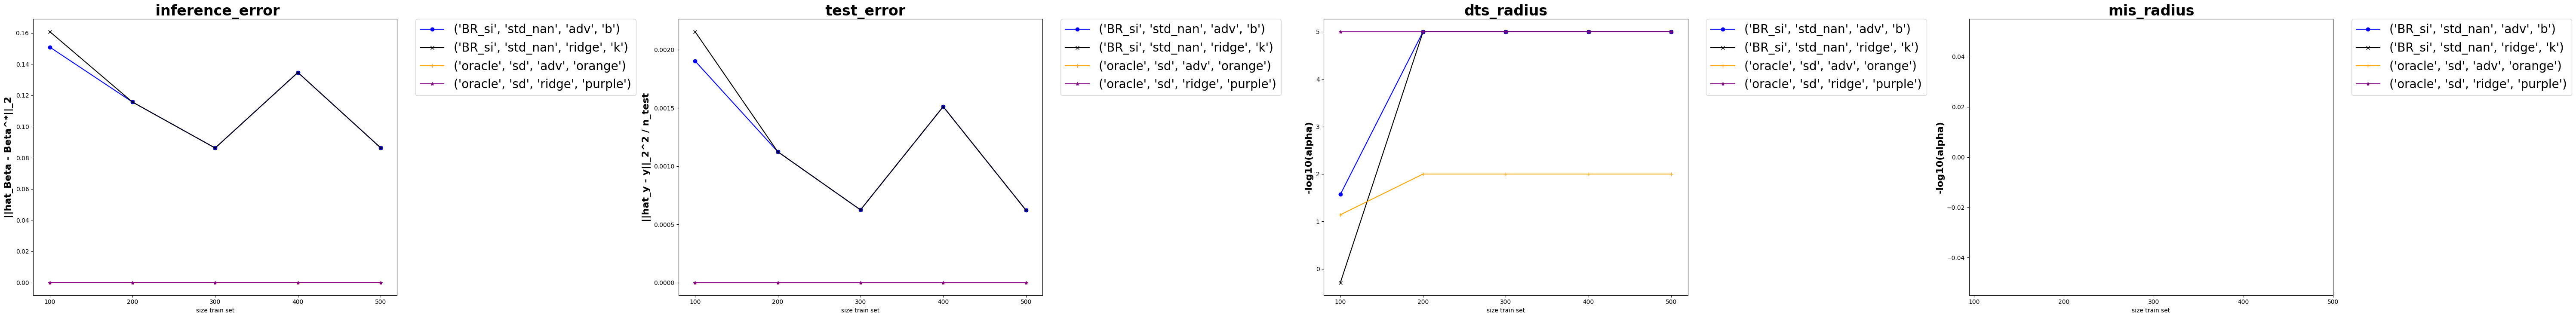

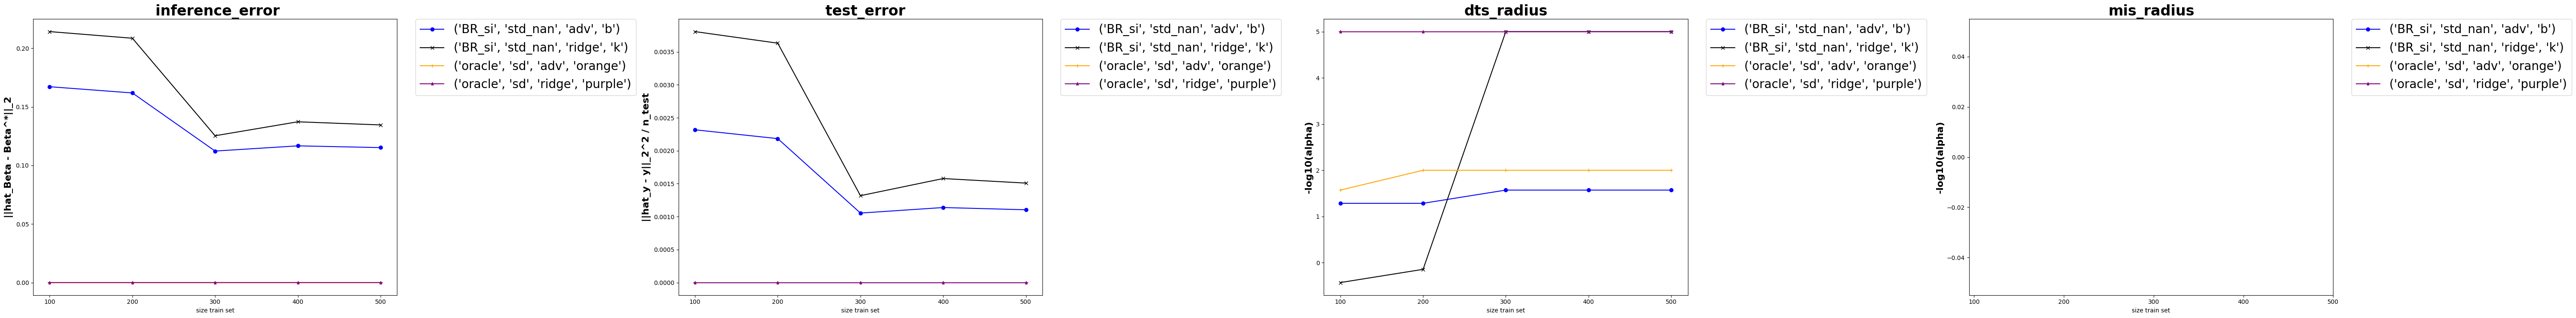

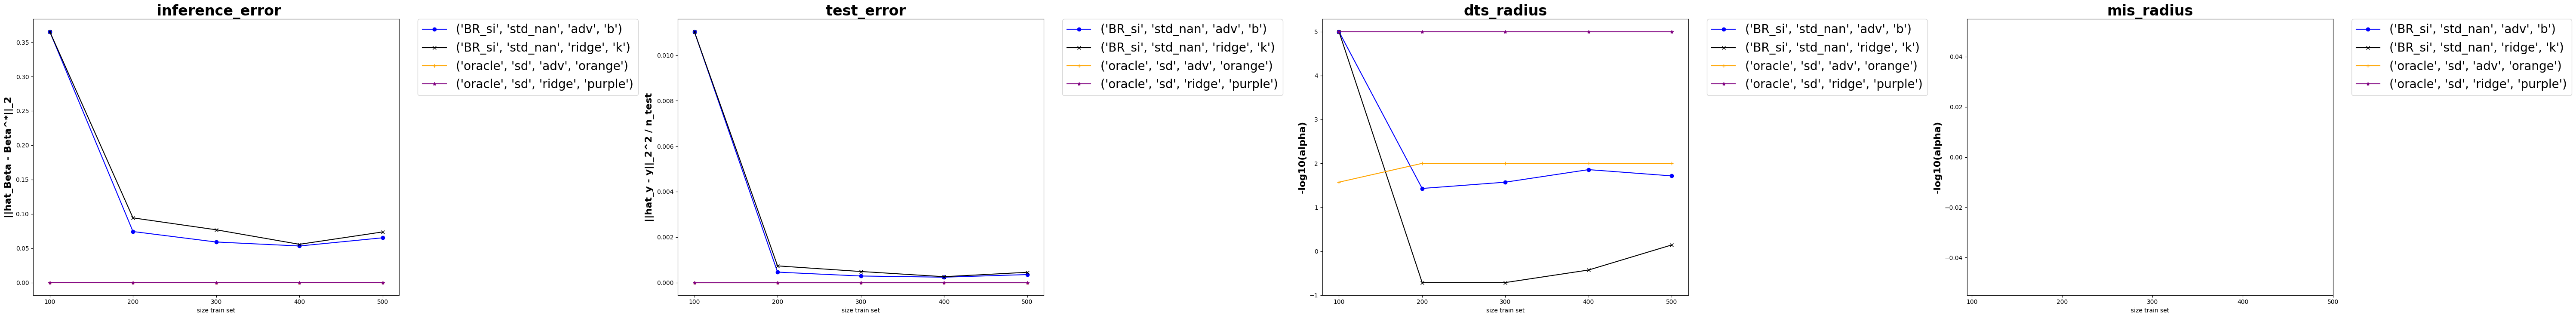

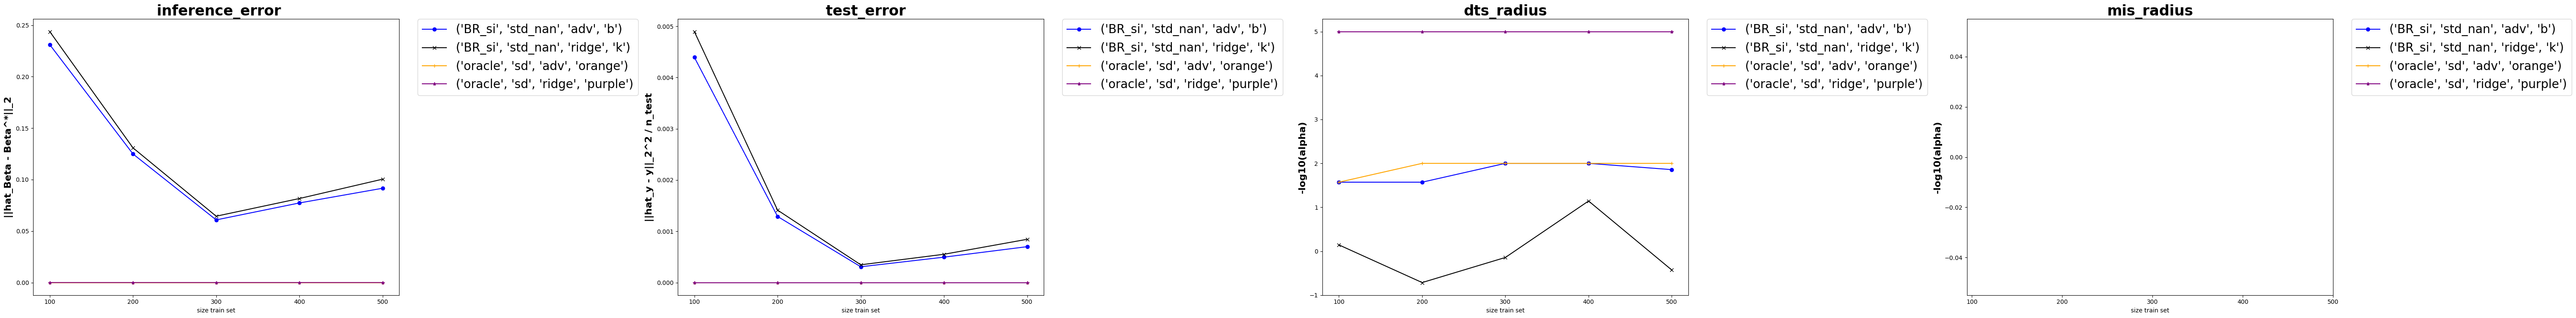

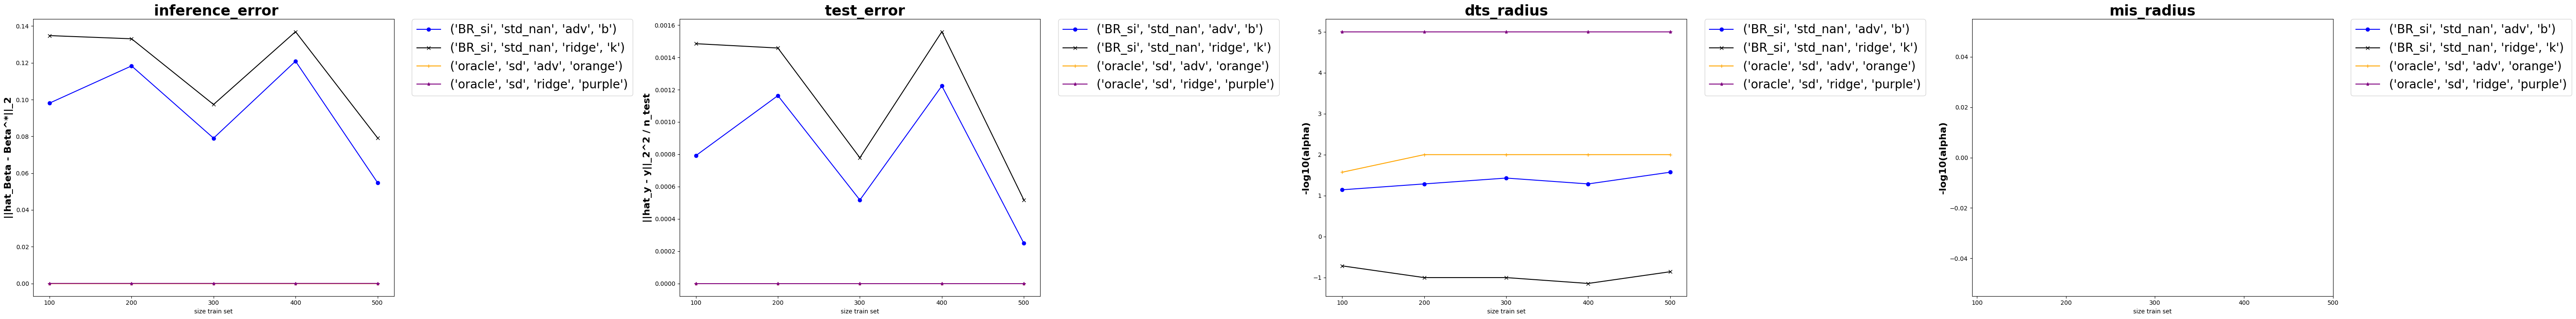

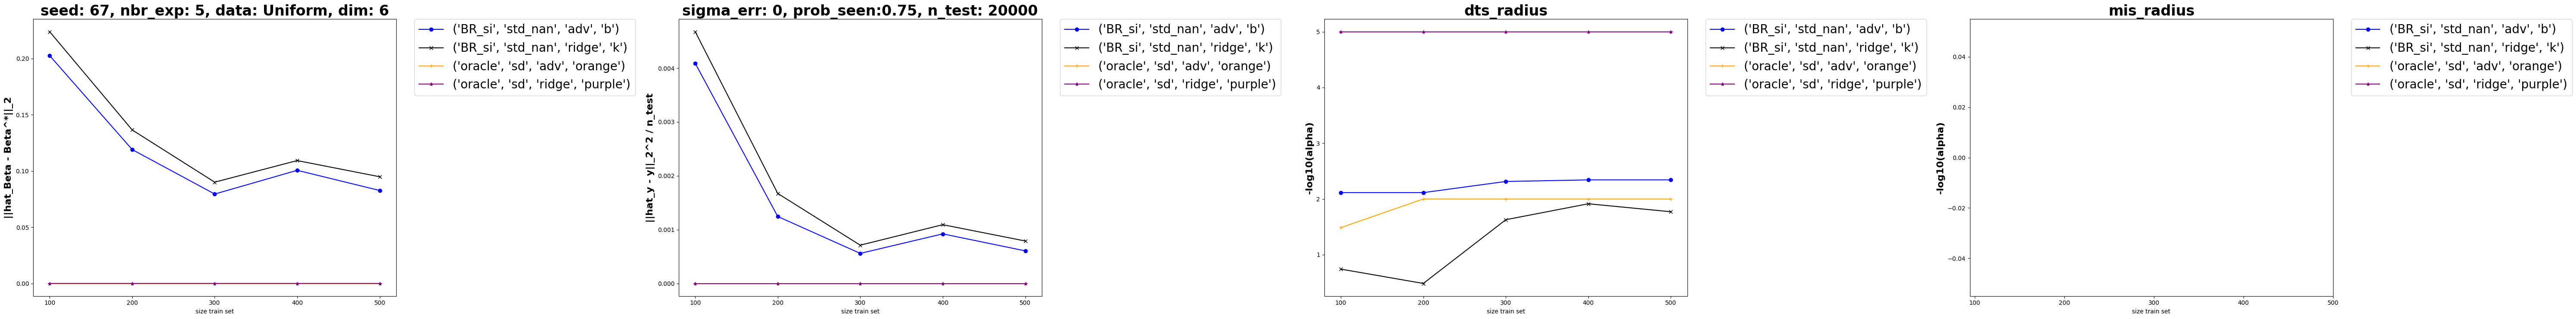

In [23]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'train'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6, 0.4/0.5, 0.3/0.4]
n_train = [100, 200, 300, 400, 500]  # check how dataset are generated, there should be some problems with 'fixed'
lenght_vec = len(n_train)
p_seen_both = [0.75, 1, 1, 1, 1, 1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
error_vec =  [0] * length_vec
#p_seen = make_probabilities(p_seen_both)
p_seen = [p_seen_both] * length_vec
if info_axis == 'train':
  main_vec = n_train
  fix_vec = 'prob_seen:' + str(p_seen_both[0])
elif info_axis == 'p_seen':
  main_vec = np.cumprod(p_seen_both)  # p_seen_both
  fix_vec = 'n_train:' + str(n_train[0])
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
#cov_var = 0.6
#beta_gt = np.array([-0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4, 5, 6, 7, 8])
#beta_gt = np.array([2, 4, -0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4])
beta_gt = np.random.randn(6)
print(beta_gt)
dim = len(beta_gt)
mean = np.array([0] * dim)
matr = np.random.randn(dim, dim) * 1
cov = matr.T @ matr + np.eye(dim) * 0.5
# np.array([[1, cov_var], [cov_var, 1]])
data_type = 'Uniform'

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': data_type, 'mean': mean, 'cov': cov},
    beta_gt = beta_gt,
    p_miss = p_seen,
    err_vector = ['Gaussian_on_X', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts']
dicc = dicc | {'generation': gen, 'title_infer_error':' inference_error', 'title_test_error':'  test_error'}
dicc = dicc | {'title_dts_radius': 'dts_radius', 'title_mis_radius': 'mis_radius'}
dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 100, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg_max': 100,
                             'eps_adv_rad_times_delta_dts': 1e-7, 'eps_adv_rad_times_delta_mis': 1e-5, 'eps_alpha_ridge_reg': 1e-7,
                             'n_a_dts': 50, 'n_a_mis':30, 'n_a_rid': 50}}
dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts', 'best_alpha_mis']

for key, value in dicc.items():
  print(key, ": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 10
# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):

list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'adv', 'color': 'b'},  #, 'multip_dataset': 3, 'multip_missing':0},
                         {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'},  #, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        #{'imp_method': 'oracle', 'cov_strategy': 'zero', 'algo_superv_learn': 'adv'},
                        #{'imp_method': 'oracle', 'cov_strategy': 'zero', 'algo_superv_learn': 'ridge'},  #, 'multip_dataset': 3, 'multip_missing': 0}
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'},
                        #{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv'}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv', 'color': 'g'}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv', 'color': 'r'}
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv'}
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}#, 'multip_dataset': 3, 'multip_missing': 3}
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''

nbr_exp = 5
seed = 67
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', data: '+ data_type + ', dim: ' + str(dim) # ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', ' + fix_vec + ', n_test: ' + str(number_test)
#dicc['title_dts_radius'] = 'dts_radius'
#dicc['title_mis_radius'] = 'mis_radius'
#dicc = dicc | {'title_dts_radius': 'title_dts_radius', 'title_mis_radius': 'title_mis_radius'}
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
#dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts', 'best_alpha_mis']
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

#add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



In [ ]:
import numpy as np

XX = np.random.randint(1, 7, (2, 3, 3))
print(XX)
XXX = np.tile(XX, (2, 1, 1))
print(XXX)

print(np.zeros(2))

y_o = np.array([1, 2])
y_oo = np.tile(y_o, 3)
print(y_oo)


In [ ]:
import numpy as np
def generate_masks_binomial_general(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks


#mm = np.random.binomial(1, [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]], (2, 3, 3))
#print(mm)
cc = np.array([np.random.binomial(1, x, (4, 4)) for x in [0.2, 0.2, 0.2]])
print(cc)
s_cc = np.cumsum(cc, axis=0)
print(s_cc)
s_cc[s_cc>1] = 1
print(s_cc)

s_v = np.random.randint(1, 4, (3, 4))
print(s_v)
s_vv = s_v[:, None, :] * np.eye(4)
print(s_vv)









In [ ]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import ridge_regression

X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)
np.random.seed(4)
alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False, random_state=0)
for a in alphas:
  #coef, intercept = estim(X, y, a)
  coef = estim(X, y, a)
  print("coef : ", coef)
  #print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  #print("coef : ", coef)
  #print("intercpt ", intercept)


lg = np.random.logistic(loc=0.0, scale=1.0, size=(4, 3))
print("log res ", lg)

